In [1]:
from typing import Union

import numpy as np
import pandas as pd
import torch
from torch import nn
from torch import optim
import torch.optim.lr_scheduler as lr_scheduler
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.decomposition

from lib.data_preprocessing import remove_correlated_columns, normalize_data
from lib.ds.bird_classes import NUM_CLASSES
from lib.ds.dataset_loading import load_all_data, flatten
from lib.ds.dataset_splitting import split
from lib.ds.torch_dataset import create_data_loader
from lib.ds.challenge_dataset import load_challenge_data
from lib.model.attention_classifier import AttentionClassifier, AttentionClassifierHyperParameters
from lib.torch_generic_model_training import train_model_with_cv
from lib.training_hyper_parameters import TrainingHyperParameters
from lib.ds.numpy_dataset import NumpyDataset
from lib.model.model_persistence import save_model, load_model
from lib.random import set_random_seed
from lib.metrics import calculate_average_metrics_for_final_epoch_of_folds, calculate_average_metrics_per_epoch, calculate_average_metrics
from lib.ds.bird_combiner import combine_birds
from lib.challenge import predict_for_challenge, save_results_to_csv, load_results_from_csv
from lib.label_fixing import fix_labels_information_gain
import lib.torch_device as tdev

%load_ext autoreload
%autoreload 2

In [2]:
# tdev.PREFERRED = 'cpu'
device = tdev.get_torch_device()
device

device(type='cuda', index=0)

In [3]:
data_raw, labels = load_all_data('dataset')
print(f'{data_raw.shape = }')
print(f'{labels.shape   = }')

data_raw.shape = (1200, 100, 548)
labels.shape   = (1200, 100)


In [39]:
dataset_raw_train, dataset_raw_test = split(NumpyDataset(data_raw, labels), test_size_pct=0.0, seed=6942066)


print(f'{dataset_raw_train.data.shape = }')
print(f'{dataset_raw_test.data.shape  = }' if dataset_raw_test is not None else 'dataset_raw_test             = None')

dataset_raw_train.data.shape = (1200, 100, 548)
dataset_raw_test             = None


### Create sequences

In [43]:
sequences_ds_train = combine_birds(
    dataset_raw_train, 
    sequence_length=300,
    random_seed=42
)
print(f'{sequences_ds_train.data.shape   = }')
print(f'{sequences_ds_train.labels.shape = }\n\n')


sequences_ds_test = combine_birds(
    dataset_raw_test, 
    sequence_length=300,
    random_seed=42
)

if sequences_ds_test is not None:
    print(f'{sequences_ds_test.data.shape   = }')
    print(f'{sequences_ds_test.labels.shape = }')
else:
    print('sequences_ds_test = None')

Creating random sequence (num_duplicates = 1): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120000/120000 [02:03<00:00, 971.10it/s]

sequences_ds_train.data.shape   = (400, 300, 548)
sequences_ds_train.labels.shape = (400, 300)


sequences_ds_test = None


# Hyper Parameters

In [44]:
ac_hyper_parameters = AttentionClassifierHyperParameters(
    in_features=data_raw.shape[-1],
    out_features=NUM_CLASSES,
    
    attention_window_size=30,
    d_model=60,
    num_heads=12,
    attention_stack_size=1,
    attention_stack_activation_provider=lambda: nn.LeakyReLU(),
    attention_dropout=0.45,
    
    in_linear_hidden_out_features=[64, 48, 48, 48],
    out_linear_hidden_out_features=[24, 16],
    linear_activation_provider=lambda: nn.LeakyReLU(),
    linear_dropout=0.45,
)

In [50]:
training_hyper_parameters = TrainingHyperParameters(
        batch_size=32,
        
        loss_weight_factors=torch.Tensor([
            1.0 / 2, # 0
            1.0, # 1
            1.0 / 1.5, # 2
            1.0, # 3
            1.0, # 4
            1.0, # 5
            1.0, # 6
        ]).to(device),
        
        optimizer_provider=lambda model, lr: optim.Adamax(
            model.parameters(),
            lr=lr,
            betas=(0.9, 0.98),
            eps=1e-9
        ),

        num_epochs=175,
        lr=1e-3,
    
        lr_scheduler_milestones=[int(m) for m in [30, 100, 250]],
        lr_scheduler_gamma=0.75,
        lr_scheduler_provider=lambda optimizer, milestones, gamma: None,
        # lr_scheduler_provider=lambda optimizer, milestones, gamma: lr_scheduler.MultiStepLR(
        #     optimizer, 
        #     milestones=milestones,
        #     gamma=gamma
        # )
    )

# Training

## Cross Validation

Creating 8 folds


CV Folds:   0%|                                                                                                                                                                                   | 0/8 [00:00<?, ?it/s]




Executing CV for fold 0
Training fold 0


#### Training ####
##################
AttentionClassifier with 62523 parameters, in_fnn: 45900, attention_stack: 14640, out_fnn: 1983
##################

train label counts = [74723,  5039,  7801,  7154,  2028,  4523,  3732]
eval label counts  = [10635,   794,  1153,  1044,   296,   588,   490]

loss weights                    = [ 0.50, 14.83,  6.39, 10.44, 36.85, 16.52, 20.02]
eval loss weights (theoretical) = [ 0.50, 13.39,  6.15, 10.19, 35.93, 18.09, 21.70]


Training Epoch   1/175: lr = 1.00E-03, epoch =     1, avg_loss = 0.000204, num_samples = 105000, num_correct =  6796, acc = 0.064724, bacc = 0.143851, score = -0.335156
Evaluation Epoch   1/175: epoch =     1, avg_loss = 0.000281, num_samples = 15000, num_correct =  1044, acc = 0.069600, bacc = 0.142857, score = -0.288988
Training Epoch   2/175: lr = 1.00E-03, epoch =     2, avg_loss = 0.000203, num_samples = 105000, num_correct =  6962, acc = 0.066305, bacc = 0.141462, score = -0.30

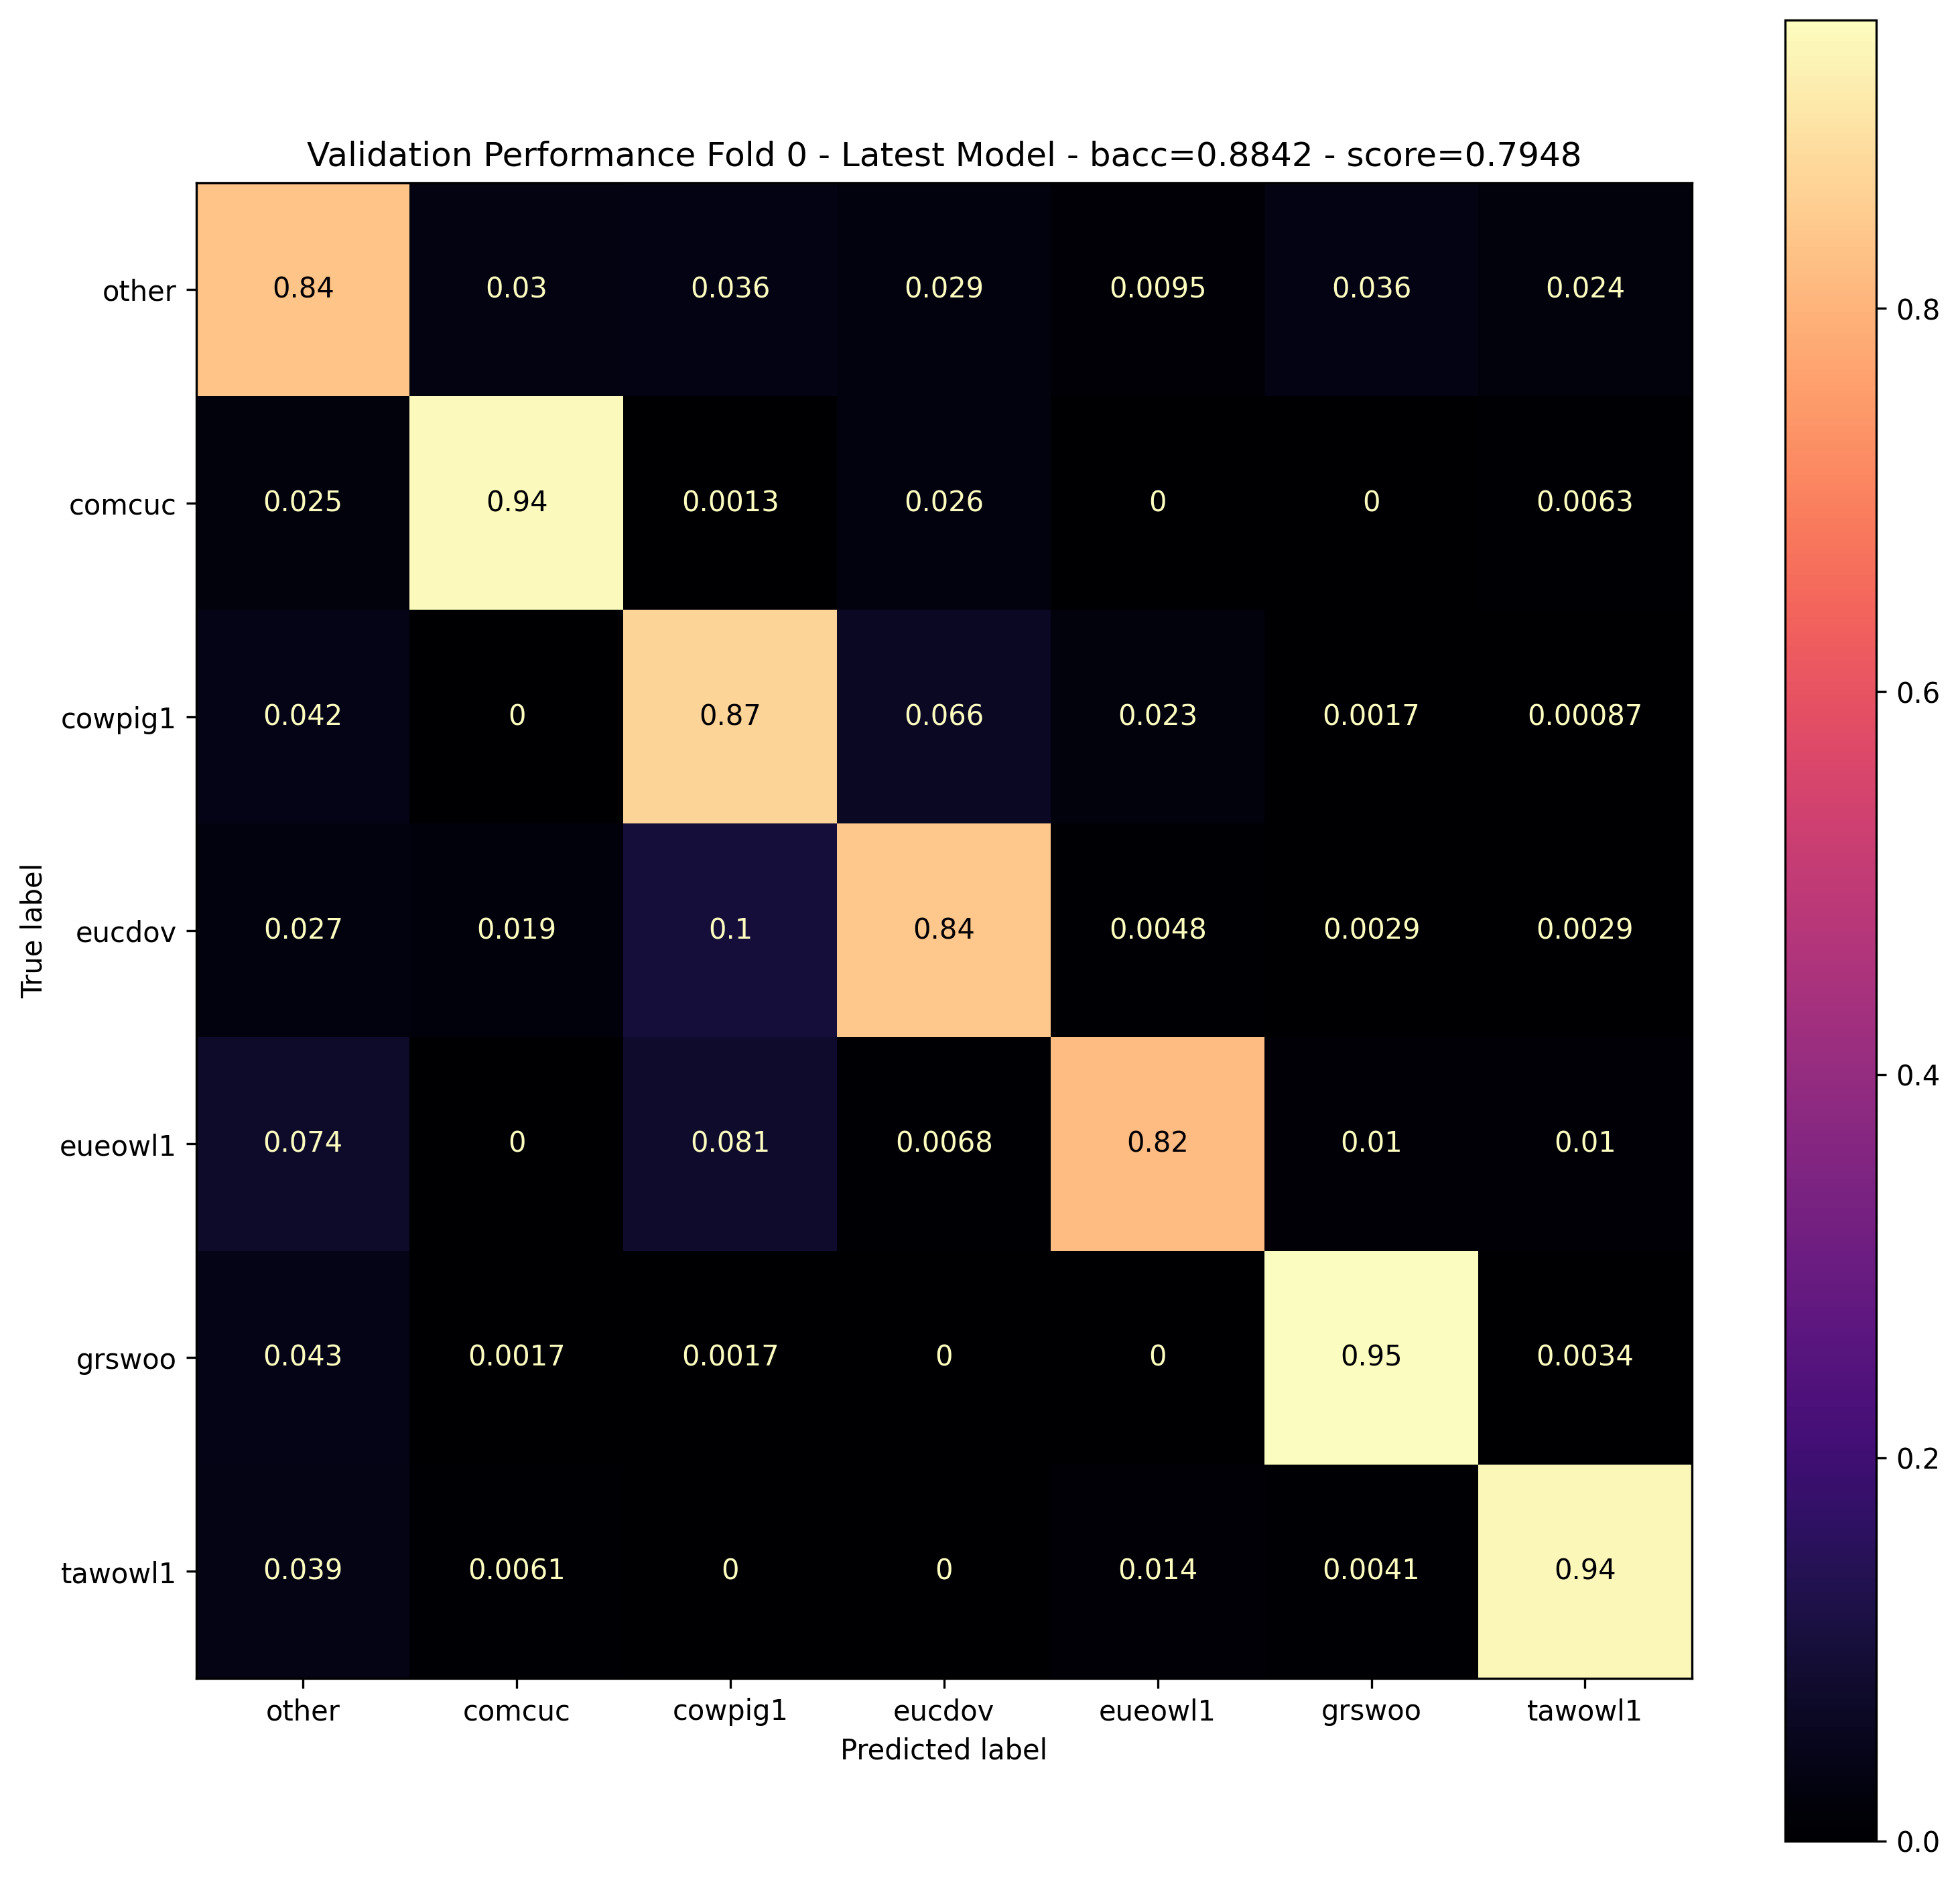

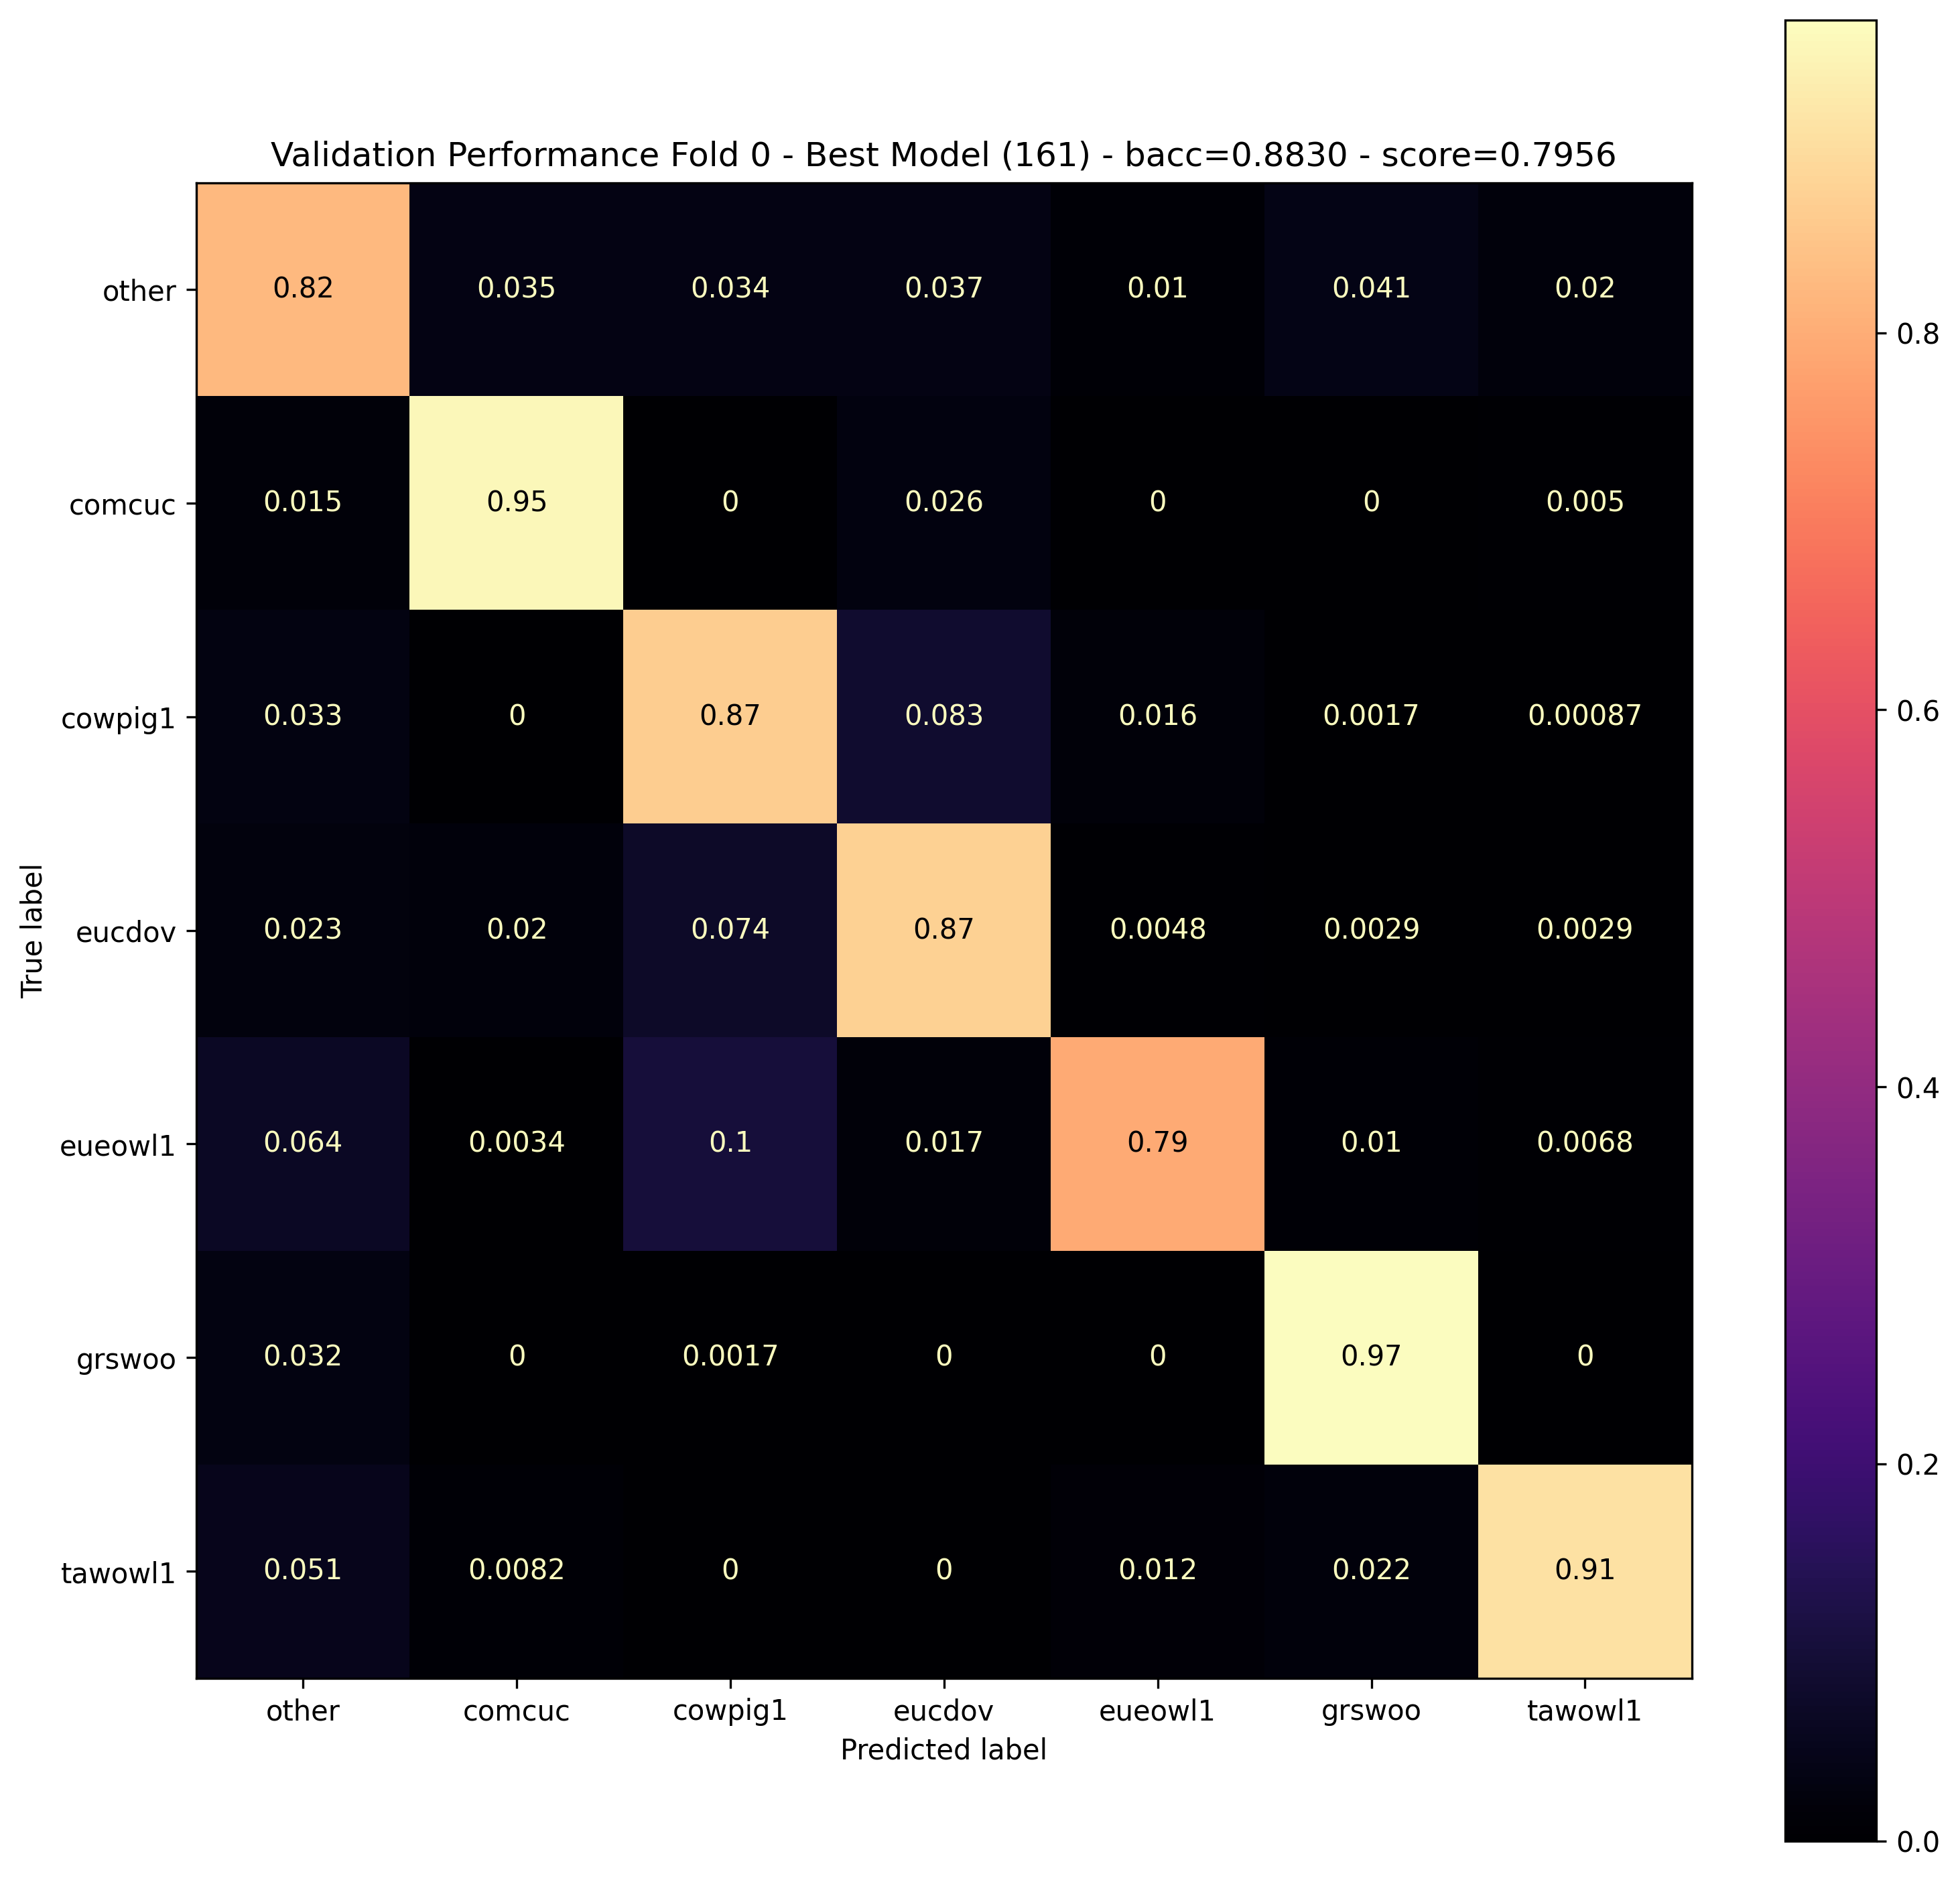

CV Folds:  12%|█████████████████████▍                                                                                                                                                     | 1/8 [00:49<05:44, 49.24s/it]

Saved model with scaler as "species_classifier cv2023-06-11_14.26 fold-0-best eval-score=0.7956"



Executing CV for fold 1
Training fold 1


#### Training ####
##################
AttentionClassifier with 62523 parameters, in_fnn: 45900, attention_stack: 14640, out_fnn: 1983
##################

train label counts = [74588,  5128,  7851,  7318,  1988,  4415,  3712]
eval label counts  = [10770,   705,  1103,   880,   336,   696,   510]

loss weights                    = [ 0.50, 14.55,  6.33, 10.19, 37.52, 16.89, 20.09]
eval loss weights (theoretical) = [ 0.50, 15.28,  6.51, 12.24, 32.05, 15.47, 21.12]


Training Epoch   1/175: lr = 1.00E-03, epoch =     1, avg_loss = 0.000204, num_samples = 105000, num_correct =  5410, acc = 0.051524, bacc = 0.141805, score = -0.366815
Evaluation Epoch   1/175: epoch =     1, avg_loss = 0.000266, num_samples = 15000, num_correct =   715, acc = 0.047667, bacc = 0.145806, score = -0.375485
Training Epoch   2/175: lr = 1.00E-03, epoch =     2, avg_loss = 0.

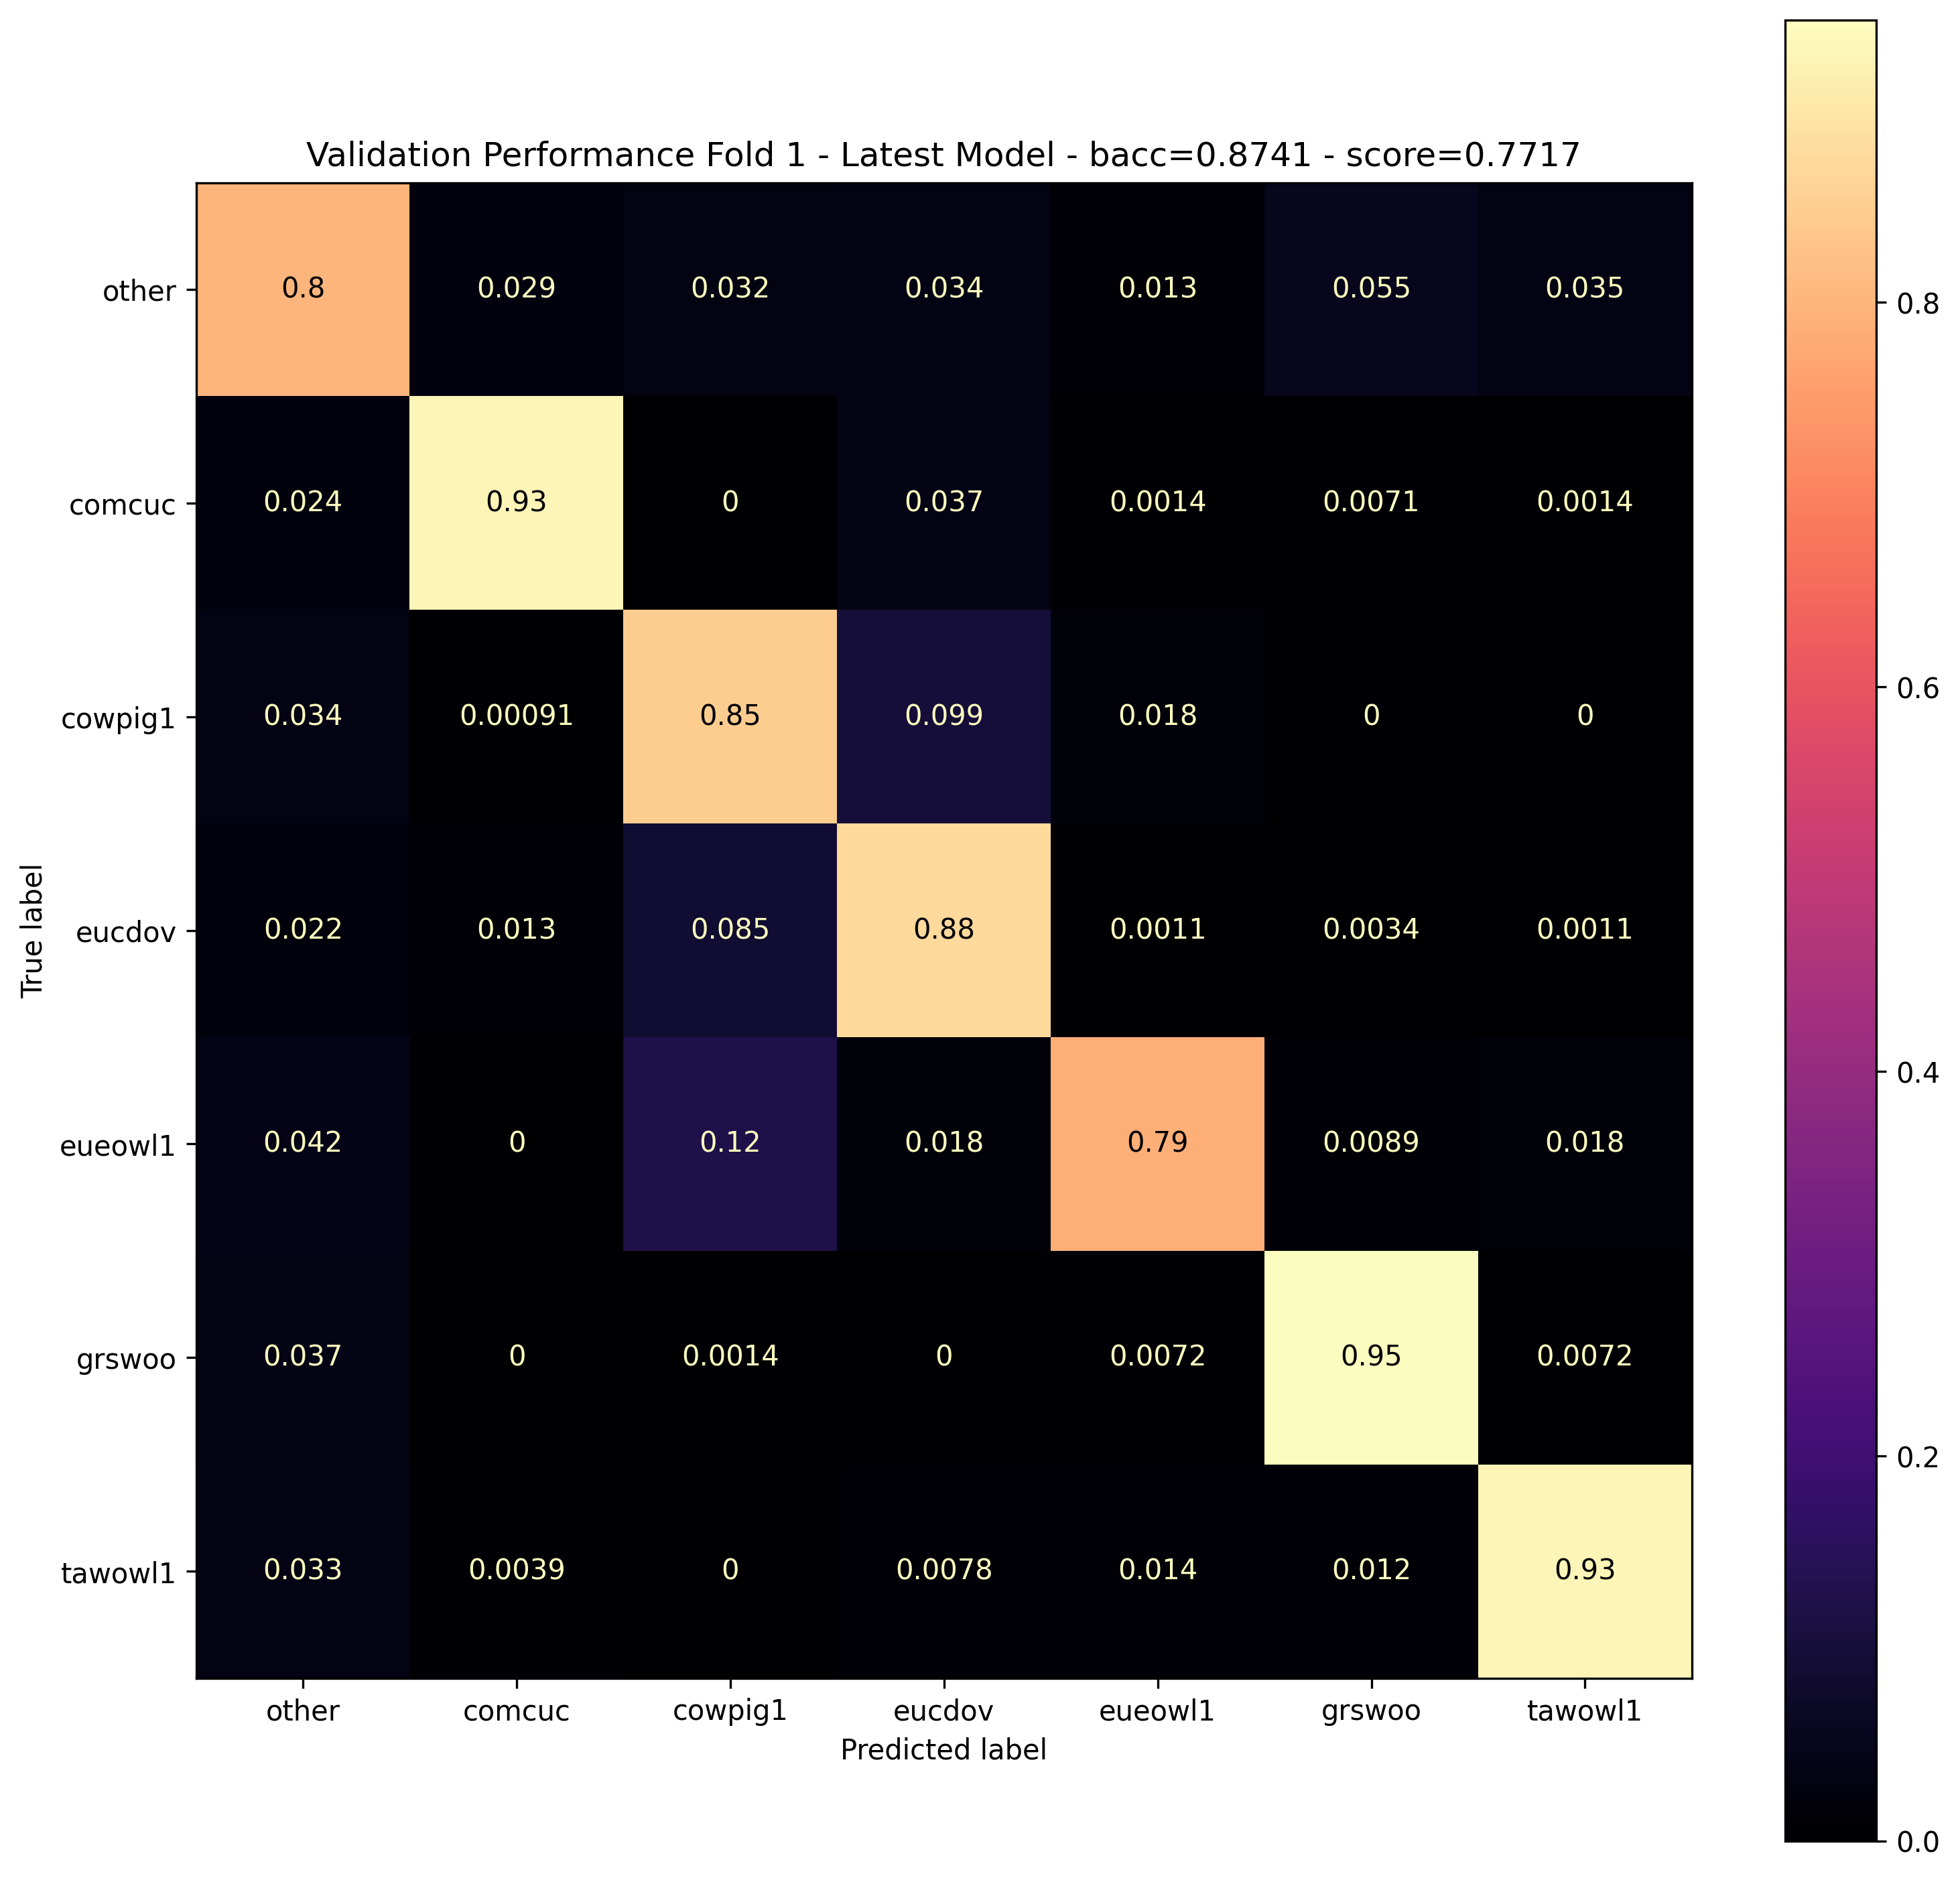

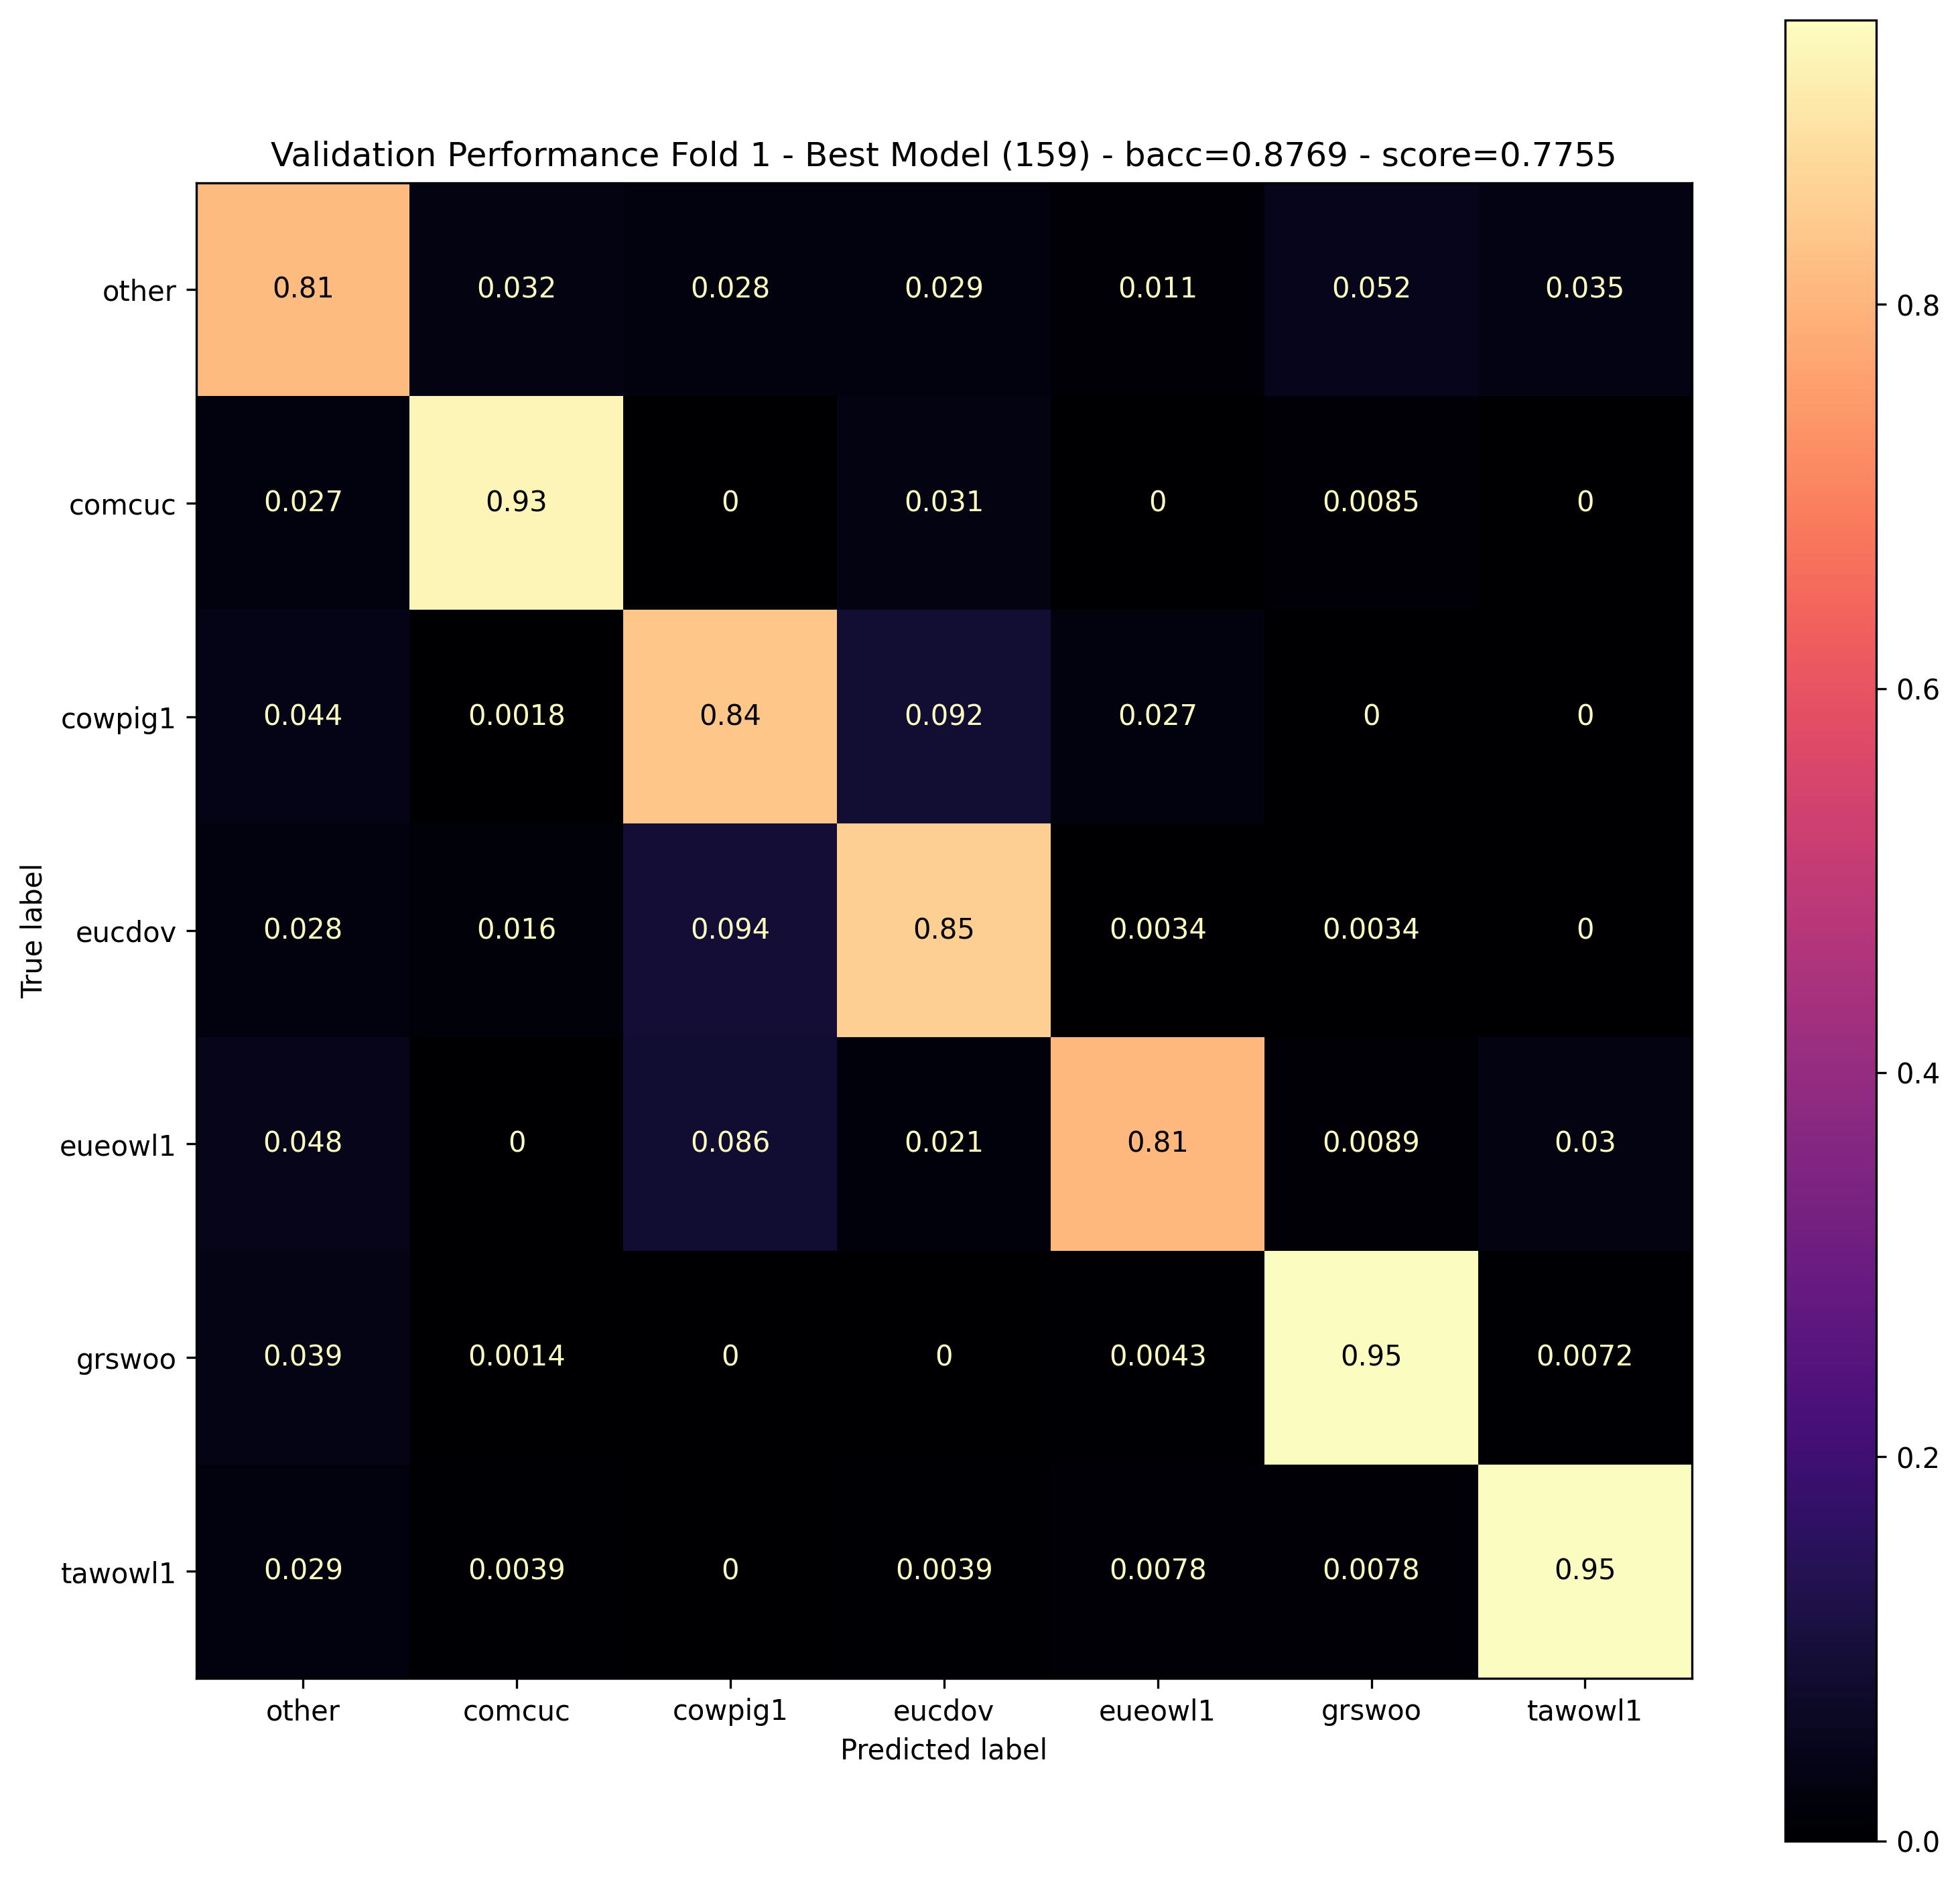

CV Folds:  25%|██████████████████████████████████████████▊                                                                                                                                | 2/8 [01:39<04:58, 49.67s/it]

Saved model with scaler as "species_classifier cv2023-06-11_14.26 fold-1-best eval-score=0.7755"



Executing CV for fold 2
Training fold 2


#### Training ####
##################
AttentionClassifier with 62523 parameters, in_fnn: 45900, attention_stack: 14640, out_fnn: 1983
##################

train label counts = [74588,  4883,  8001,  7214,  1994,  4517,  3803]
eval label counts  = [10770,   950,   953,   984,   330,   594,   419]

loss weights                    = [ 0.50, 15.28,  6.21, 10.34, 37.41, 16.51, 19.61]
eval loss weights (theoretical) = [ 0.50, 11.34,  7.53, 10.95, 32.64, 18.13, 25.70]


Training Epoch   1/175: lr = 1.00E-03, epoch =     1, avg_loss = 0.000206, num_samples = 105000, num_correct =  7518, acc = 0.071600, bacc = 0.144285, score = -0.351805
Evaluation Epoch   1/175: epoch =     1, avg_loss = 0.000266, num_samples = 15000, num_correct =   998, acc = 0.066533, bacc = 0.145551, score = -0.328279
Training Epoch   2/175: lr = 1.00E-03, epoch =     2, avg_loss = 0.

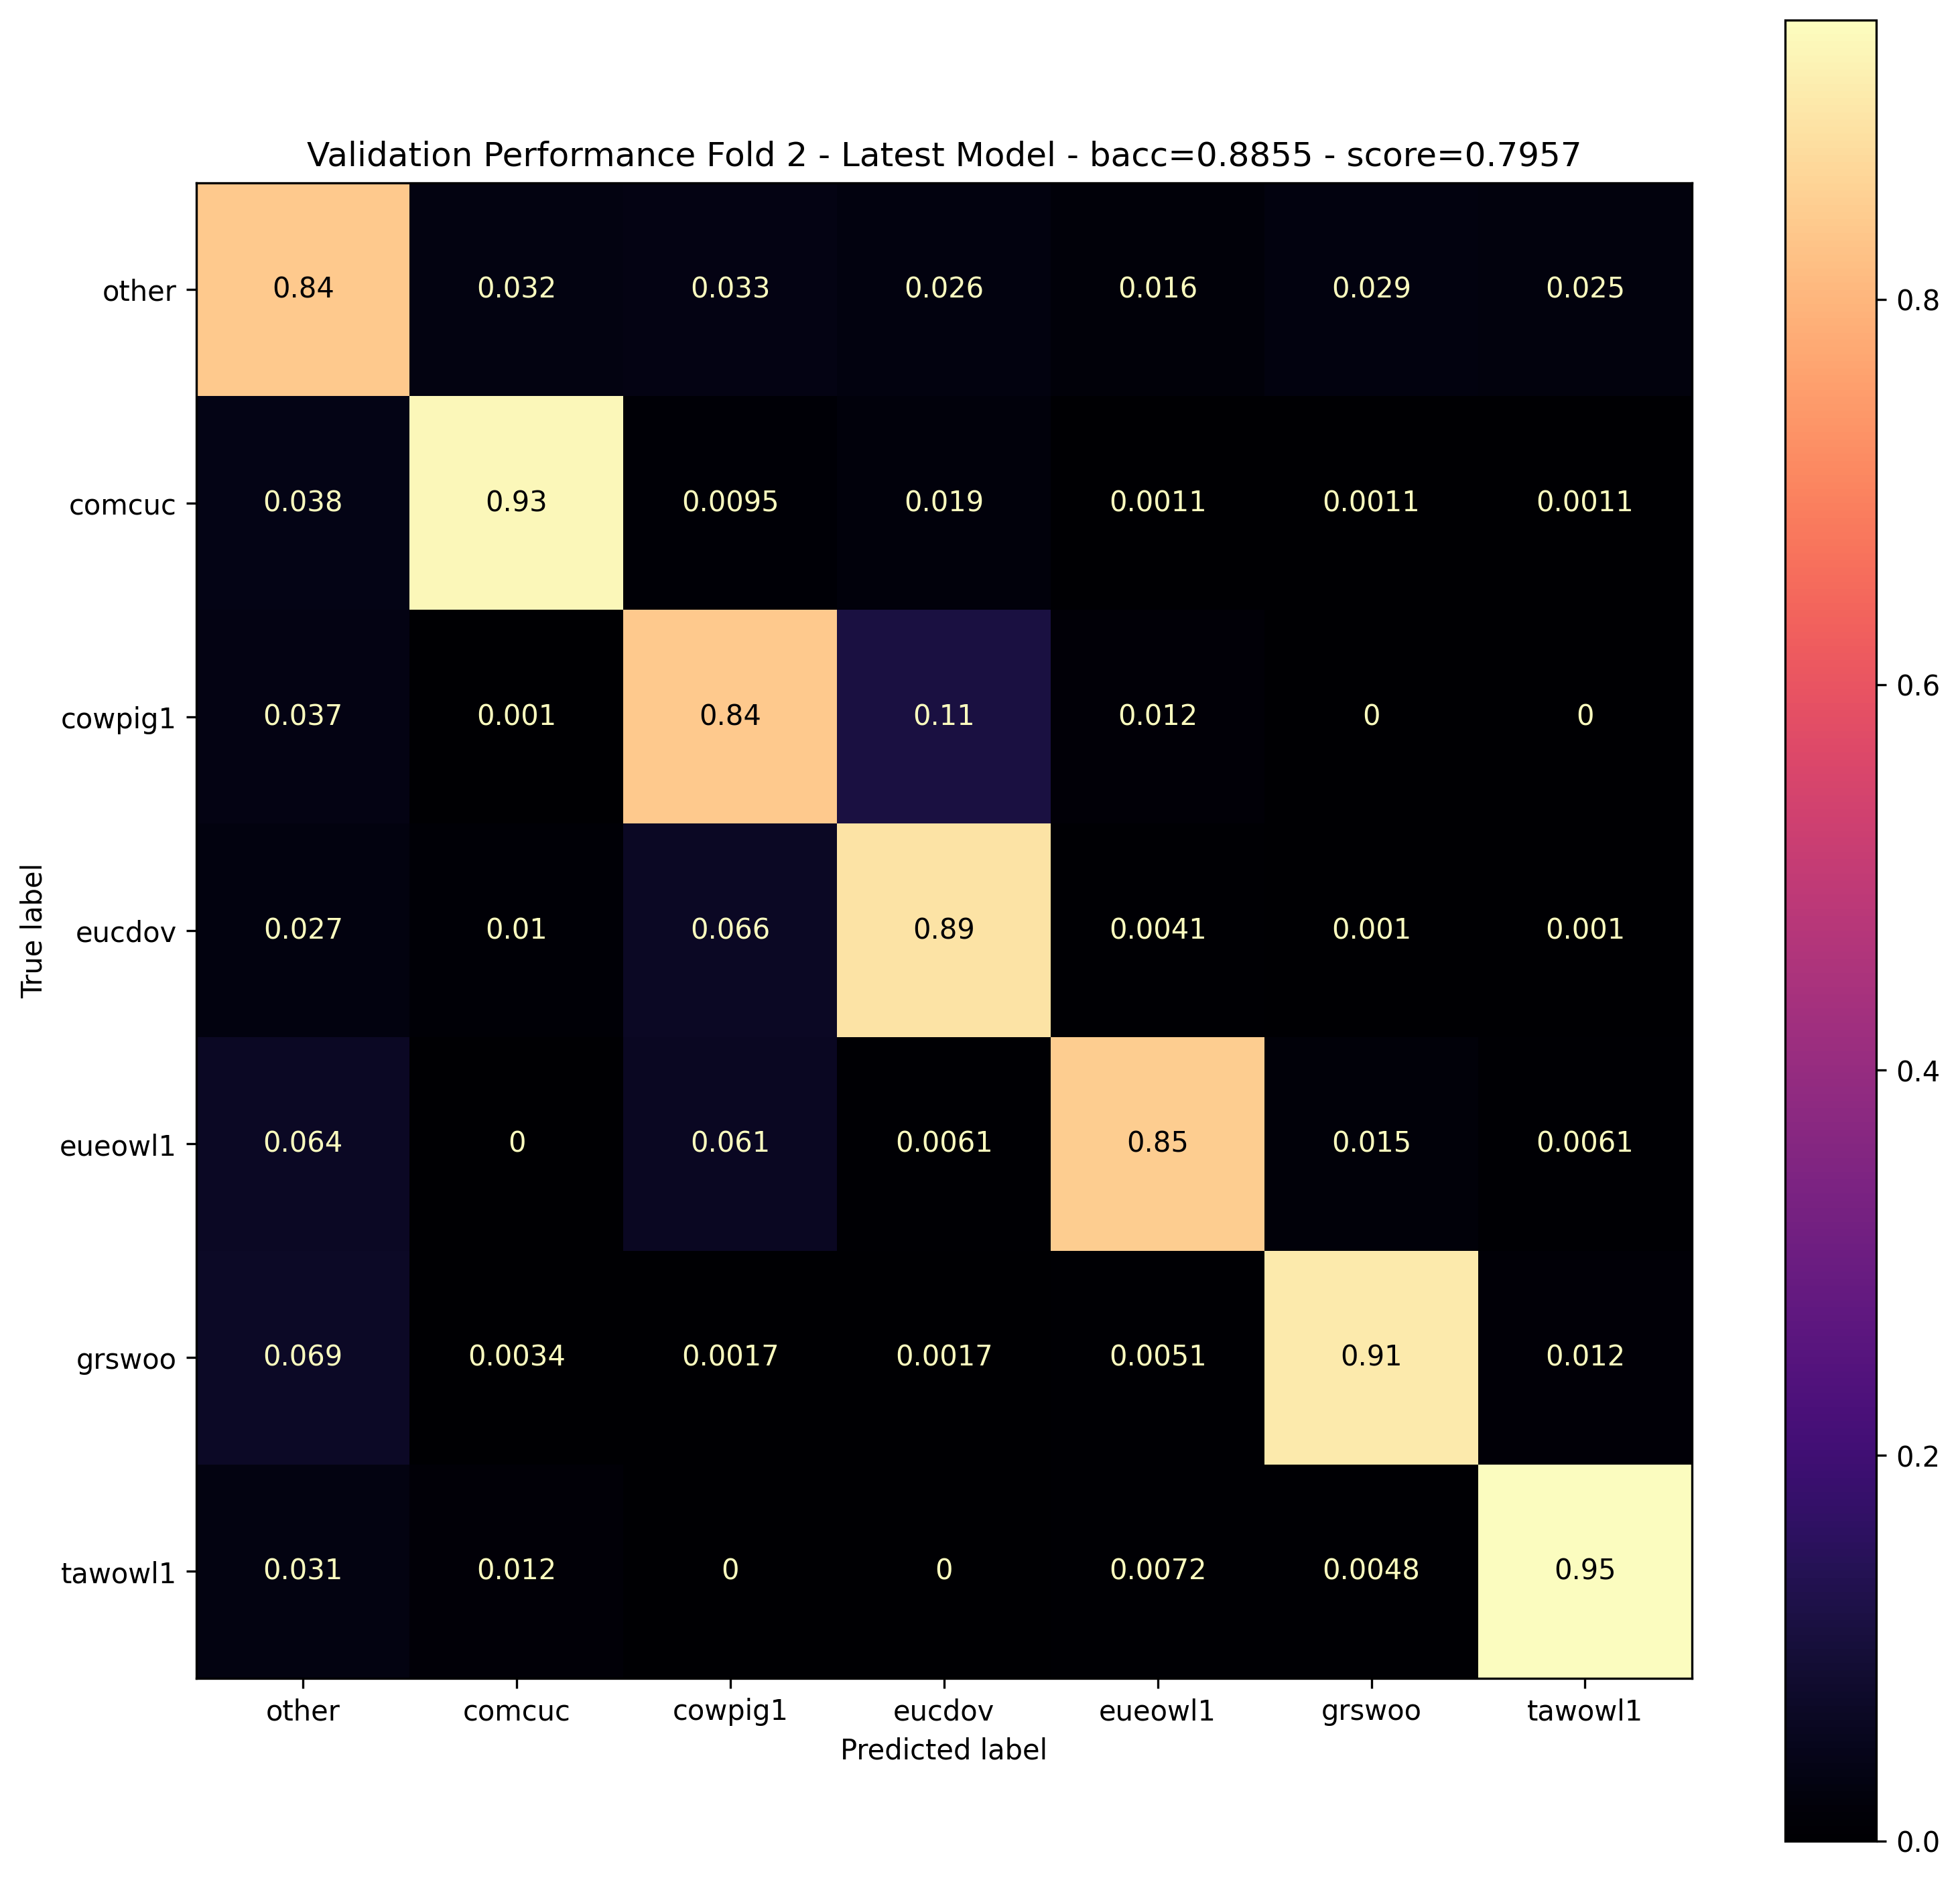

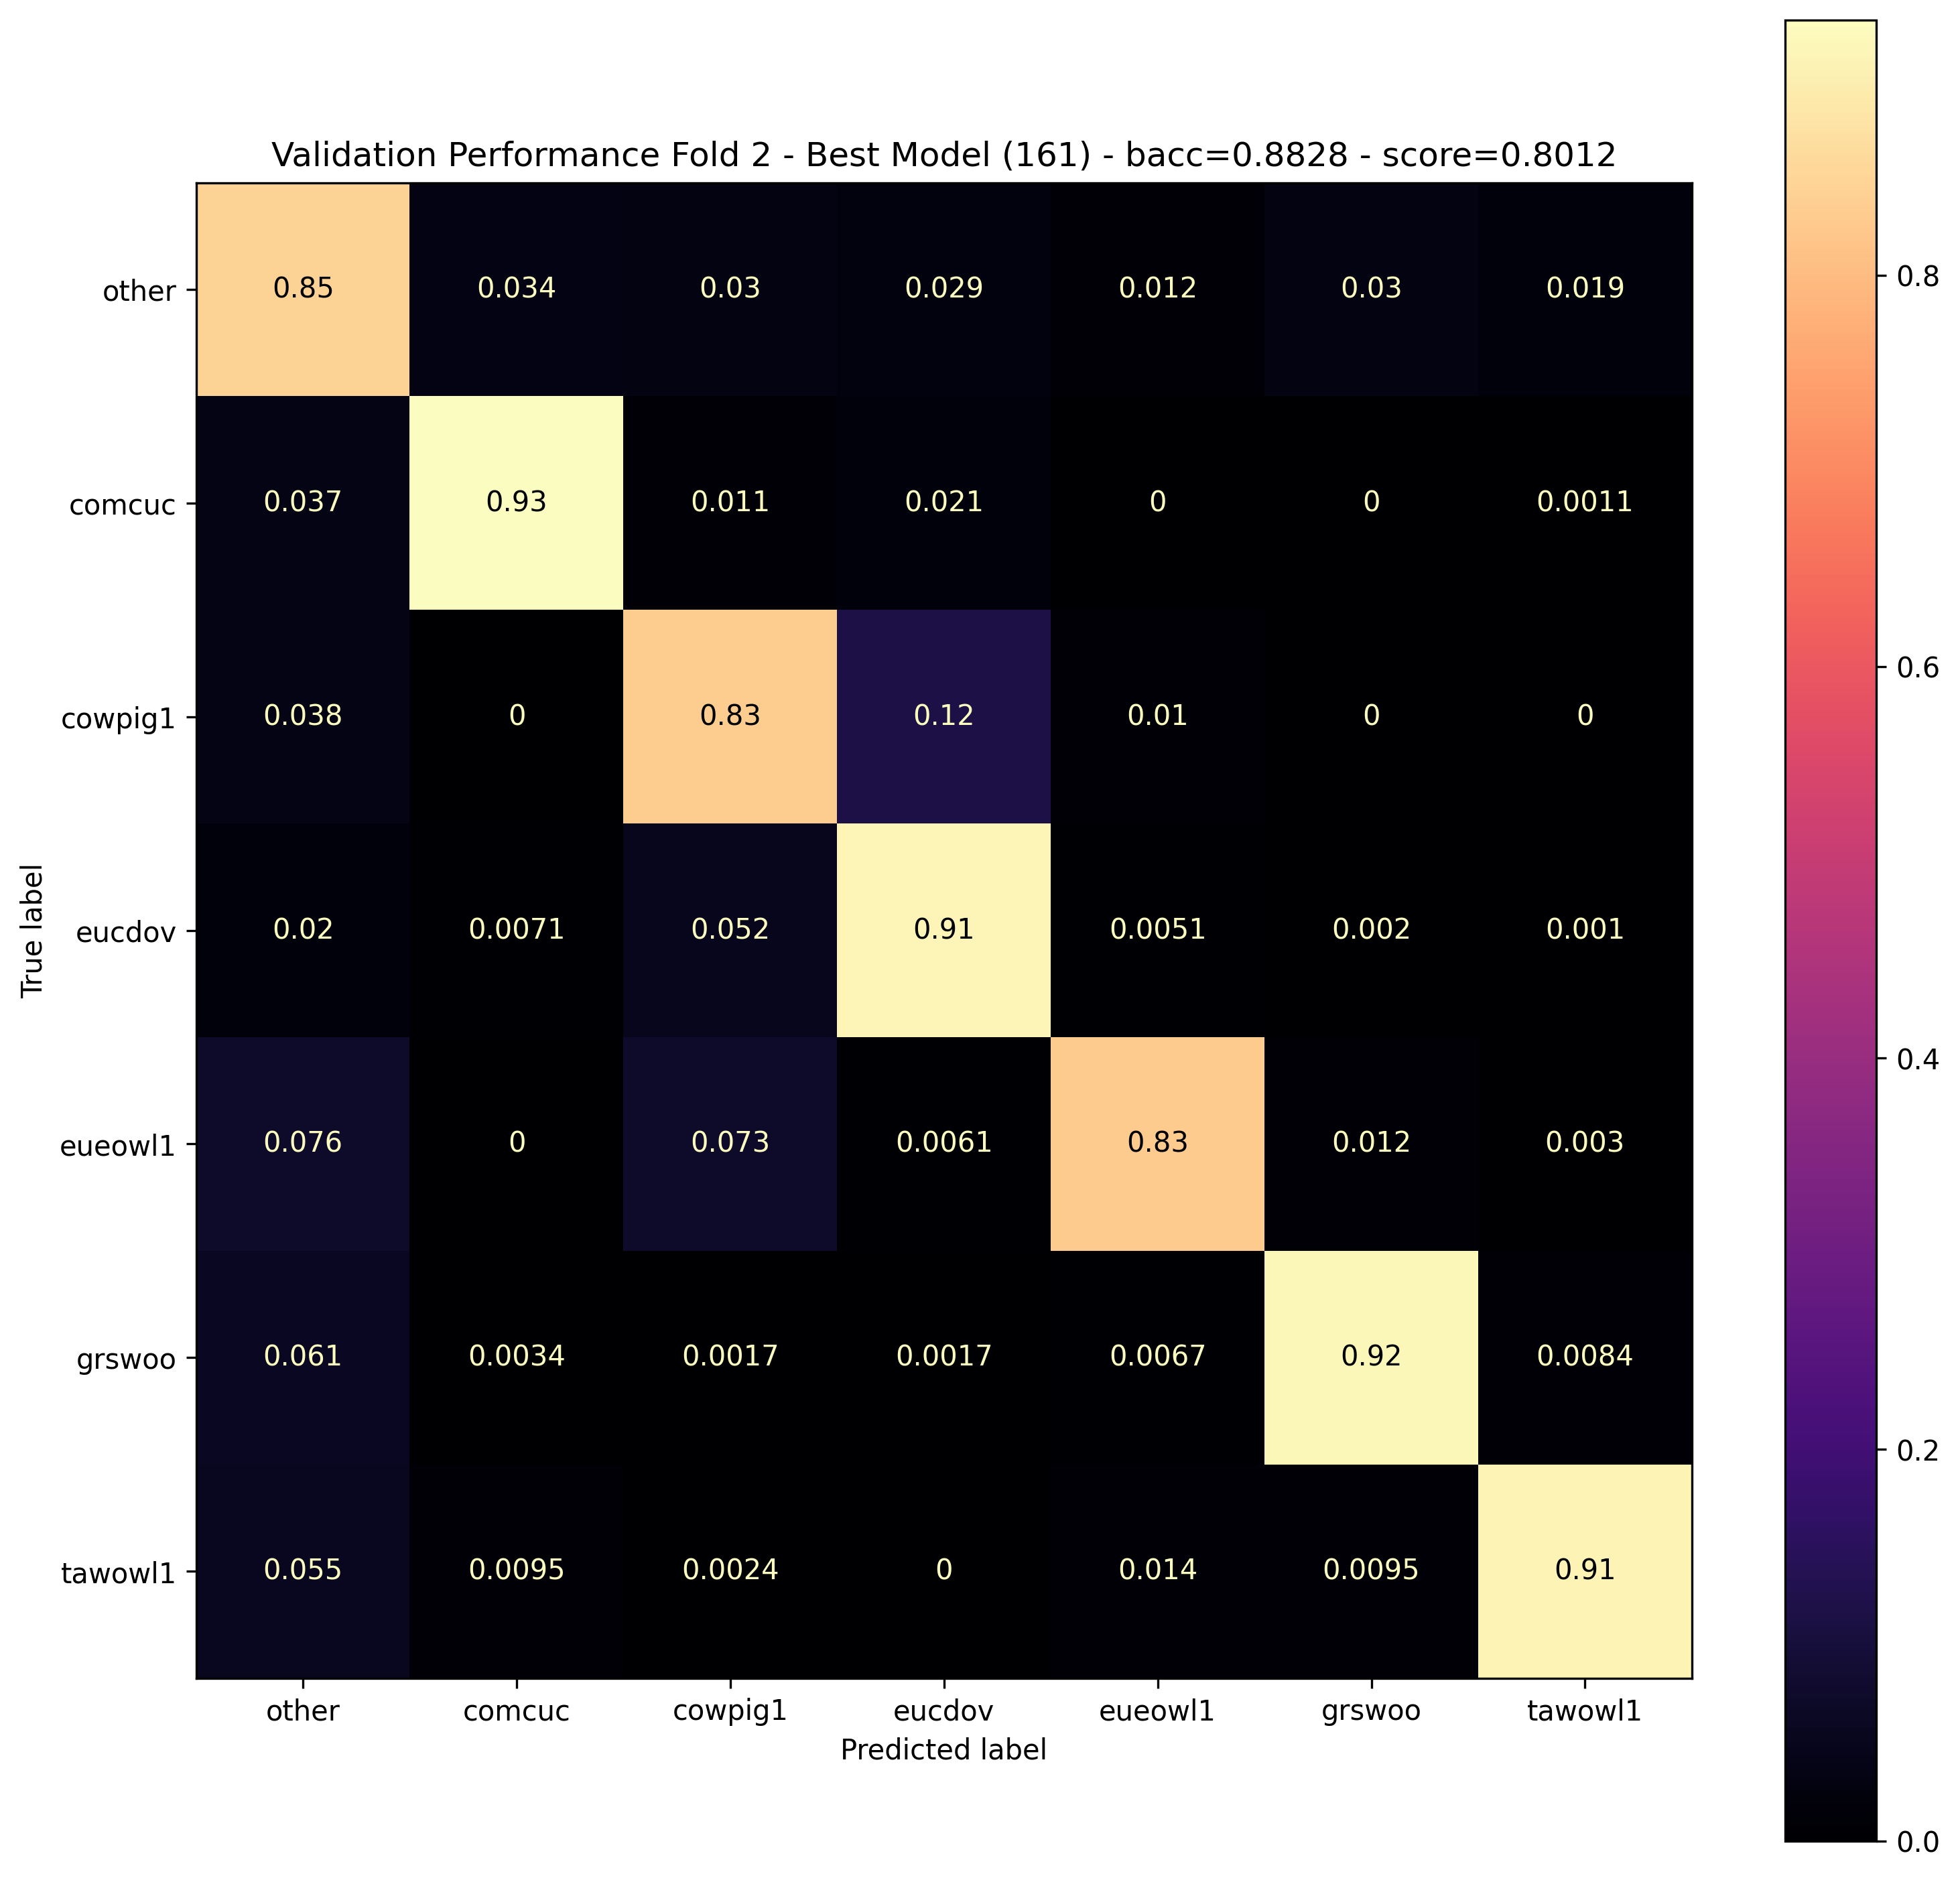

CV Folds:  38%|████████████████████████████████████████████████████████████████▏                                                                                                          | 3/8 [02:29<04:09, 49.84s/it]

Saved model with scaler as "species_classifier cv2023-06-11_14.26 fold-2-best eval-score=0.8012"



Executing CV for fold 3
Training fold 3


#### Training ####
##################
AttentionClassifier with 62523 parameters, in_fnn: 45900, attention_stack: 14640, out_fnn: 1983
##################

train label counts = [74633,  4970,  8084,  7021,  2066,  4603,  3623]
eval label counts  = [10725,   863,   870,  1177,   258,   508,   599]

loss weights                    = [ 0.50, 15.02,  6.15, 10.63, 36.12, 16.21, 20.60]
eval loss weights (theoretical) = [ 0.50, 12.43,  8.22,  9.11, 41.57, 21.11, 17.90]


Training Epoch   1/175: lr = 1.00E-03, epoch =     1, avg_loss = 0.000204, num_samples = 105000, num_correct =  4581, acc = 0.043629, bacc = 0.143103, score = -0.380956
Evaluation Epoch   1/175: epoch =     1, avg_loss = 0.000278, num_samples = 15000, num_correct =   508, acc = 0.033867, bacc = 0.142857, score = -0.418540
Training Epoch   2/175: lr = 1.00E-03, epoch =     2, avg_loss = 0.

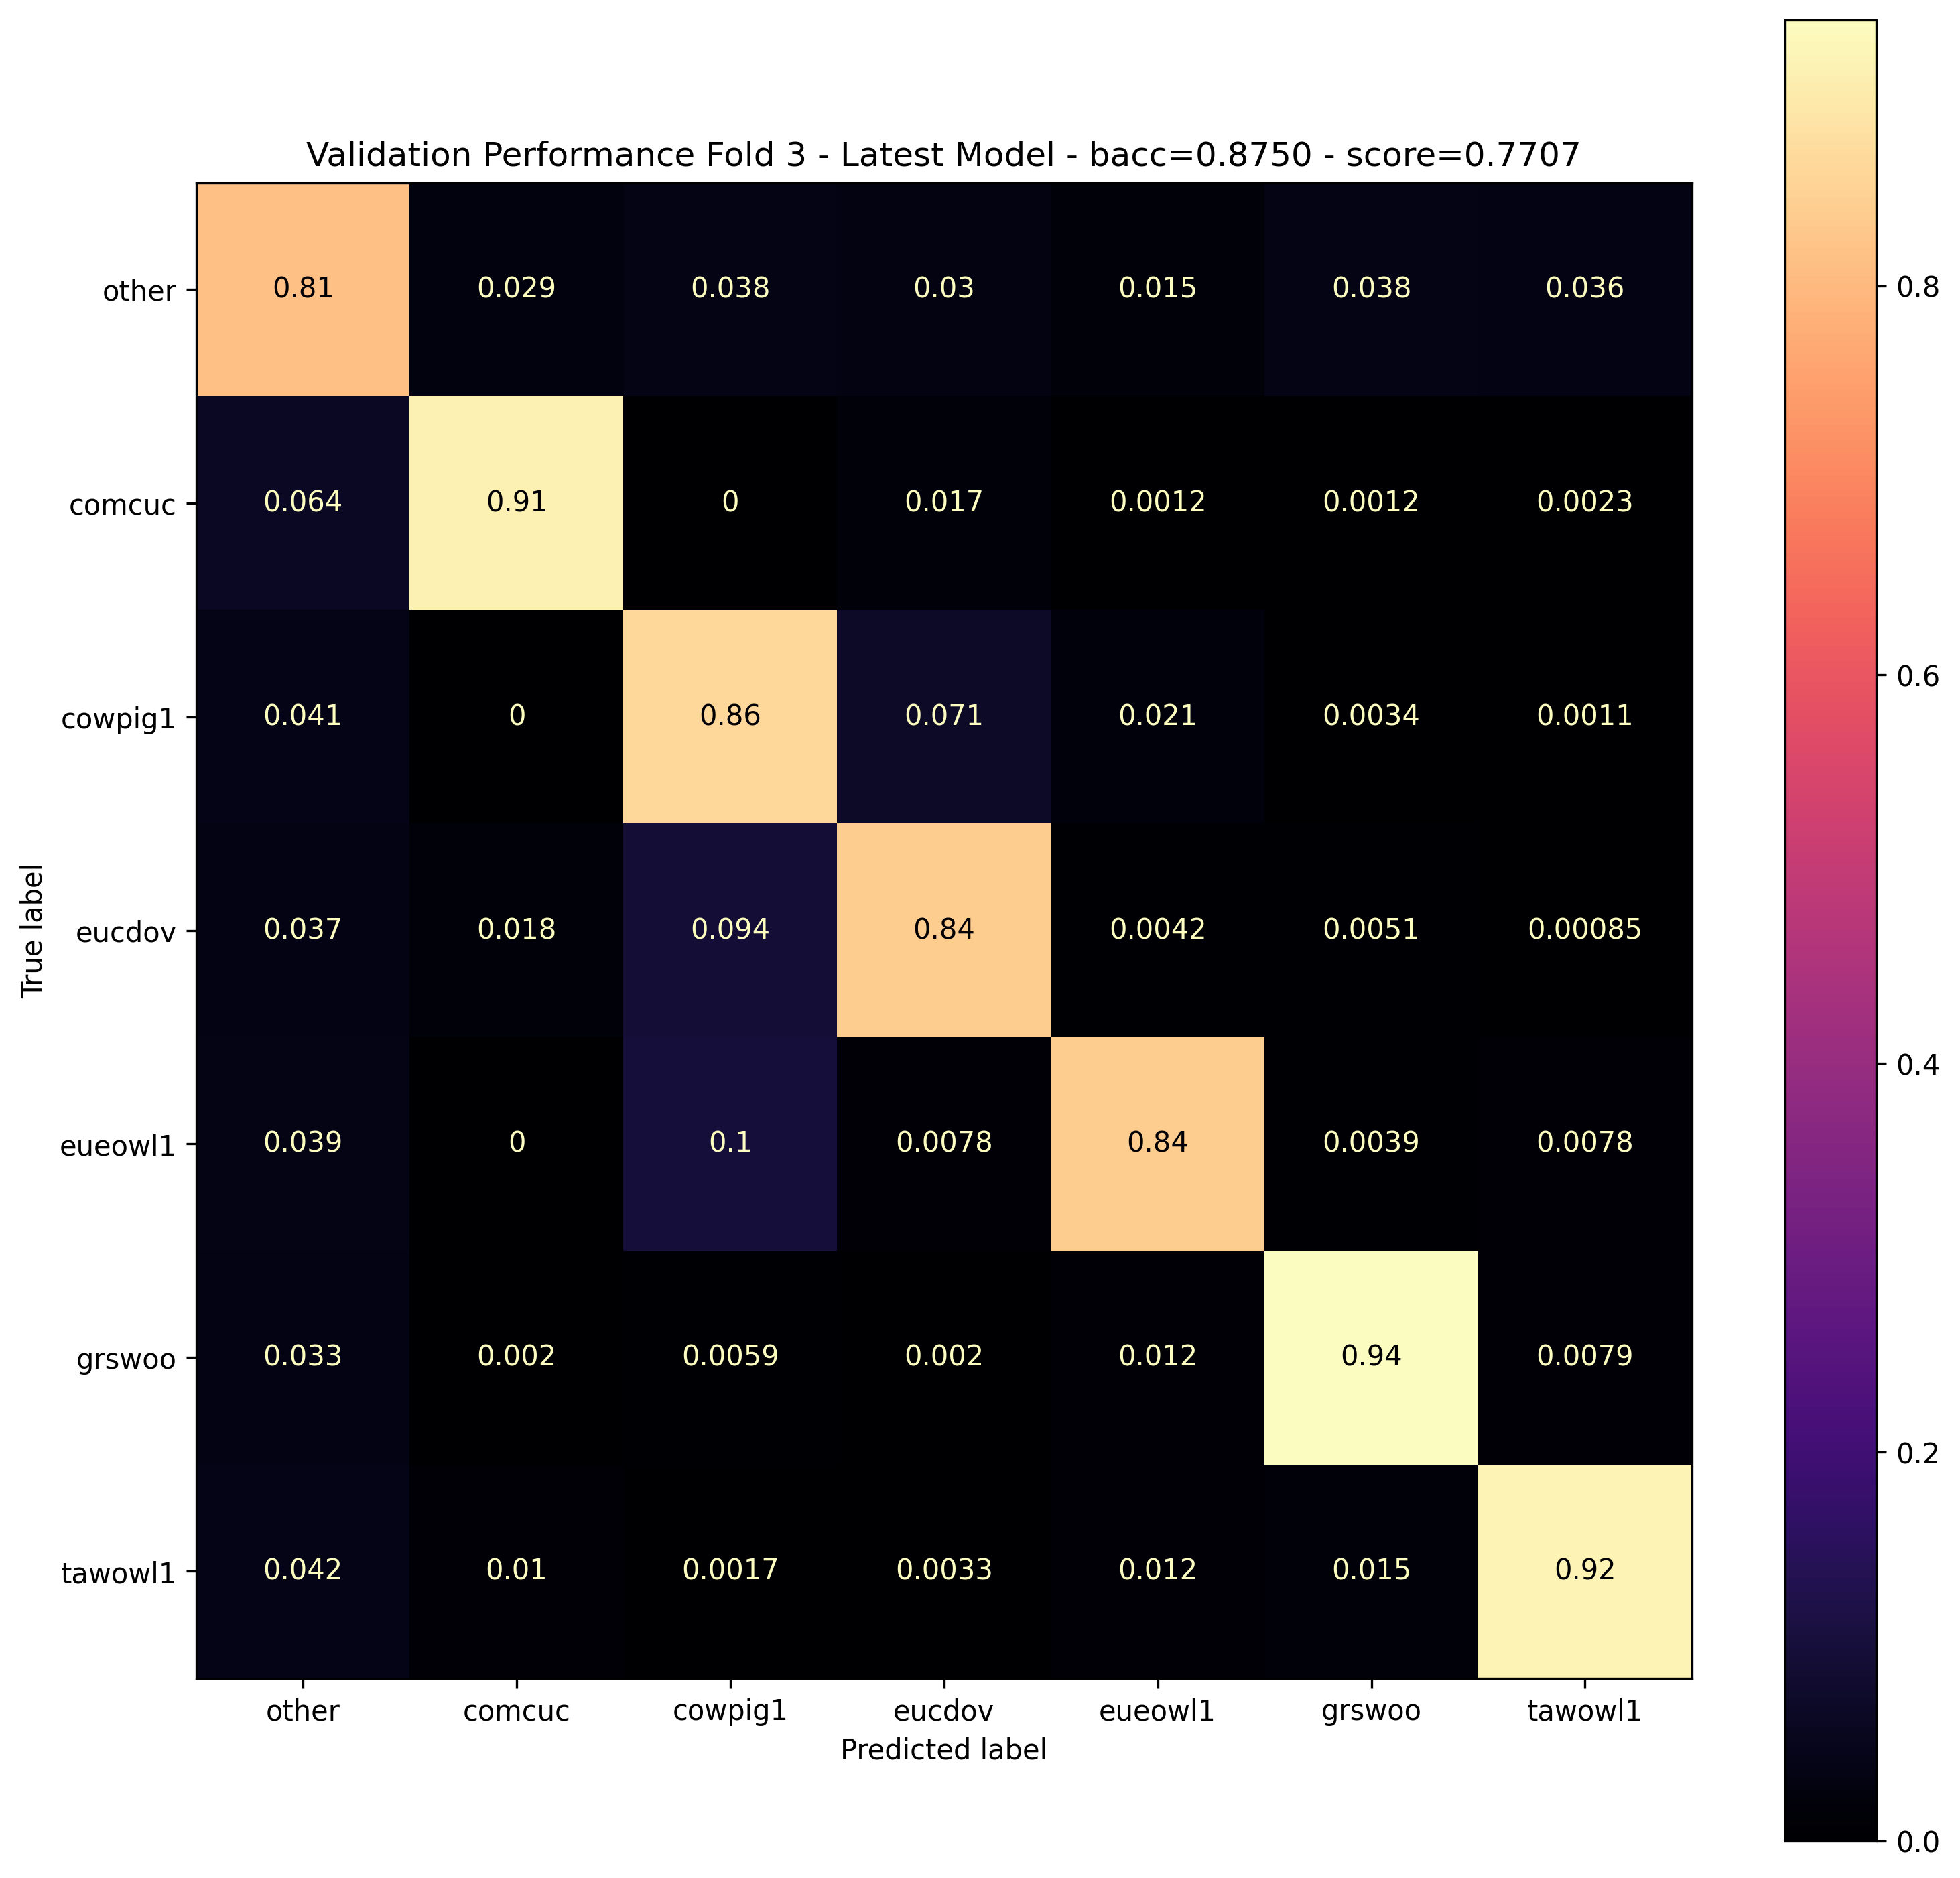

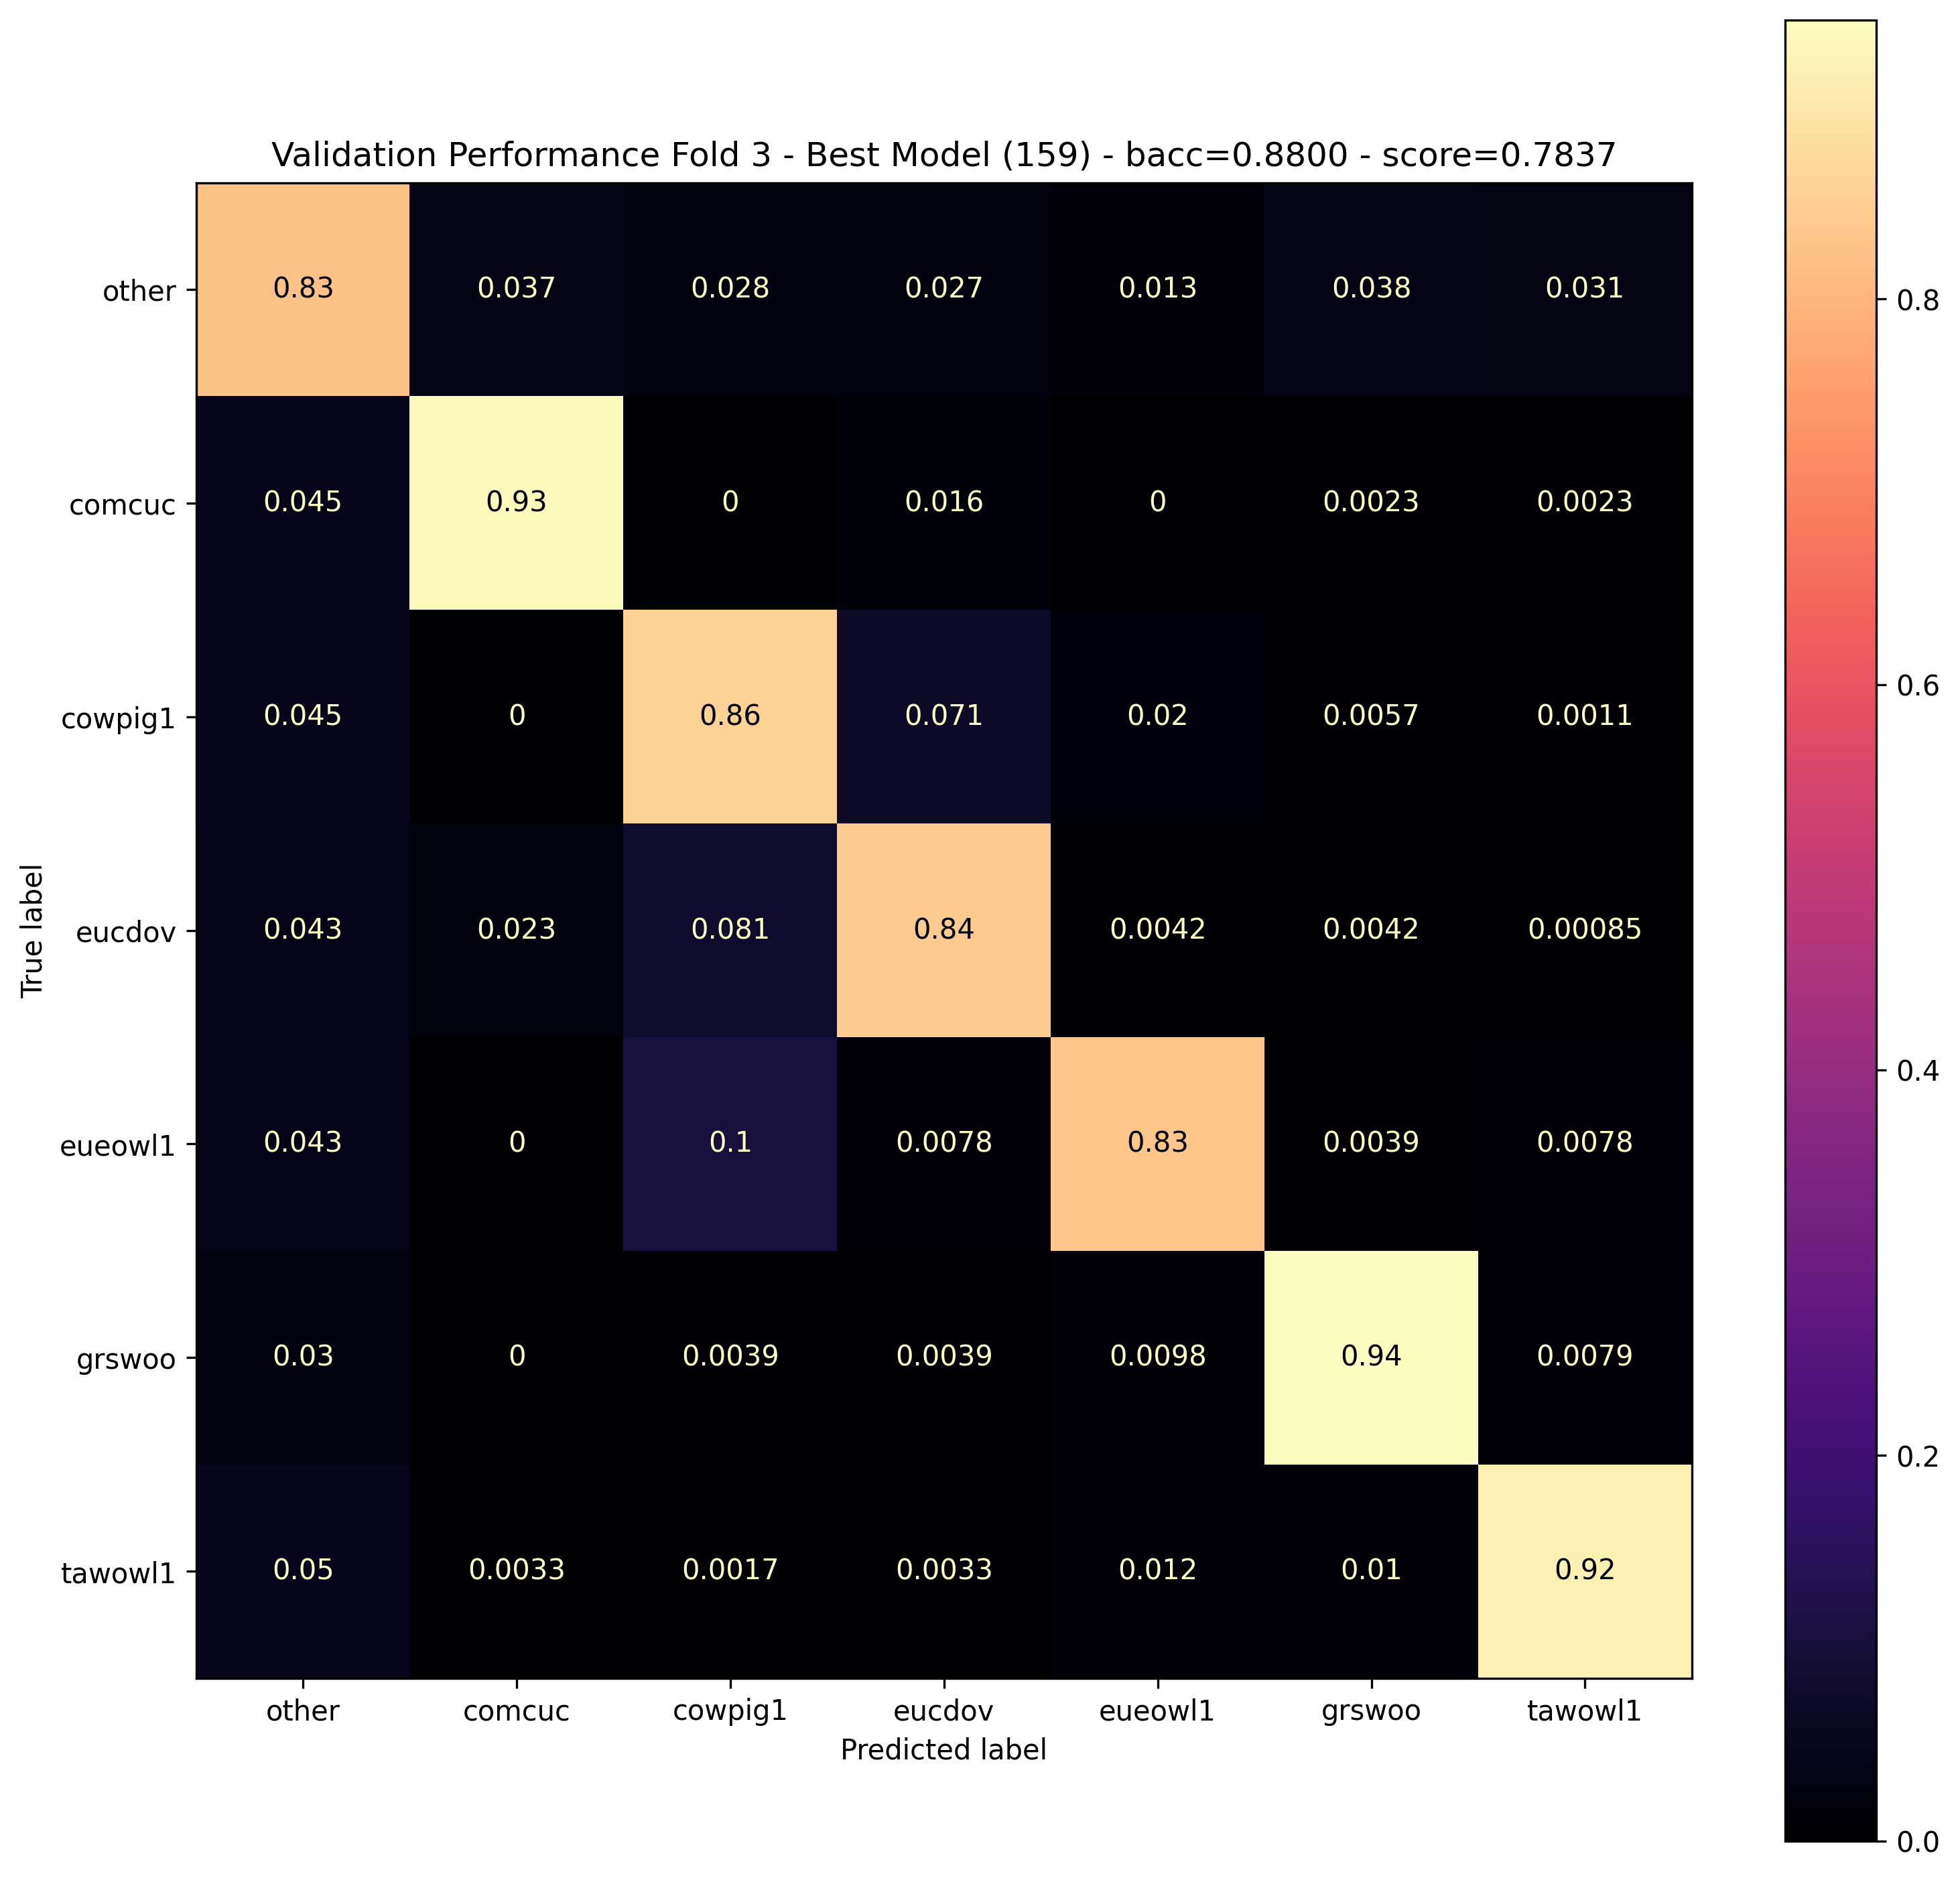

CV Folds:  50%|█████████████████████████████████████████████████████████████████████████████████████▌                                                                                     | 4/8 [03:18<03:17, 49.44s/it]

Saved model with scaler as "species_classifier cv2023-06-11_14.26 fold-3-best eval-score=0.7837"



Executing CV for fold 4
Training fold 4


#### Training ####
##################
AttentionClassifier with 62523 parameters, in_fnn: 45900, attention_stack: 14640, out_fnn: 1983
##################

train label counts = [74836,  5089,  7800,  6906,  2009,  4573,  3787]
eval label counts  = [10522,   744,  1154,  1292,   315,   538,   435]

loss weights                    = [ 0.50, 14.71,  6.40, 10.84, 37.25, 16.36, 19.76]
eval loss weights (theoretical) = [ 0.50, 14.14,  6.08,  8.14, 33.40, 19.56, 24.19]


Training Epoch   1/175: lr = 1.00E-03, epoch =     1, avg_loss = 0.000205, num_samples = 105000, num_correct =  4729, acc = 0.045038, bacc = 0.144284, score = -0.398219
Evaluation Epoch   1/175: epoch =     1, avg_loss = 0.000277, num_samples = 15000, num_correct =   435, acc = 0.029000, bacc = 0.142857, score = -0.414400
Training Epoch   2/175: lr = 1.00E-03, epoch =     2, avg_loss = 0.

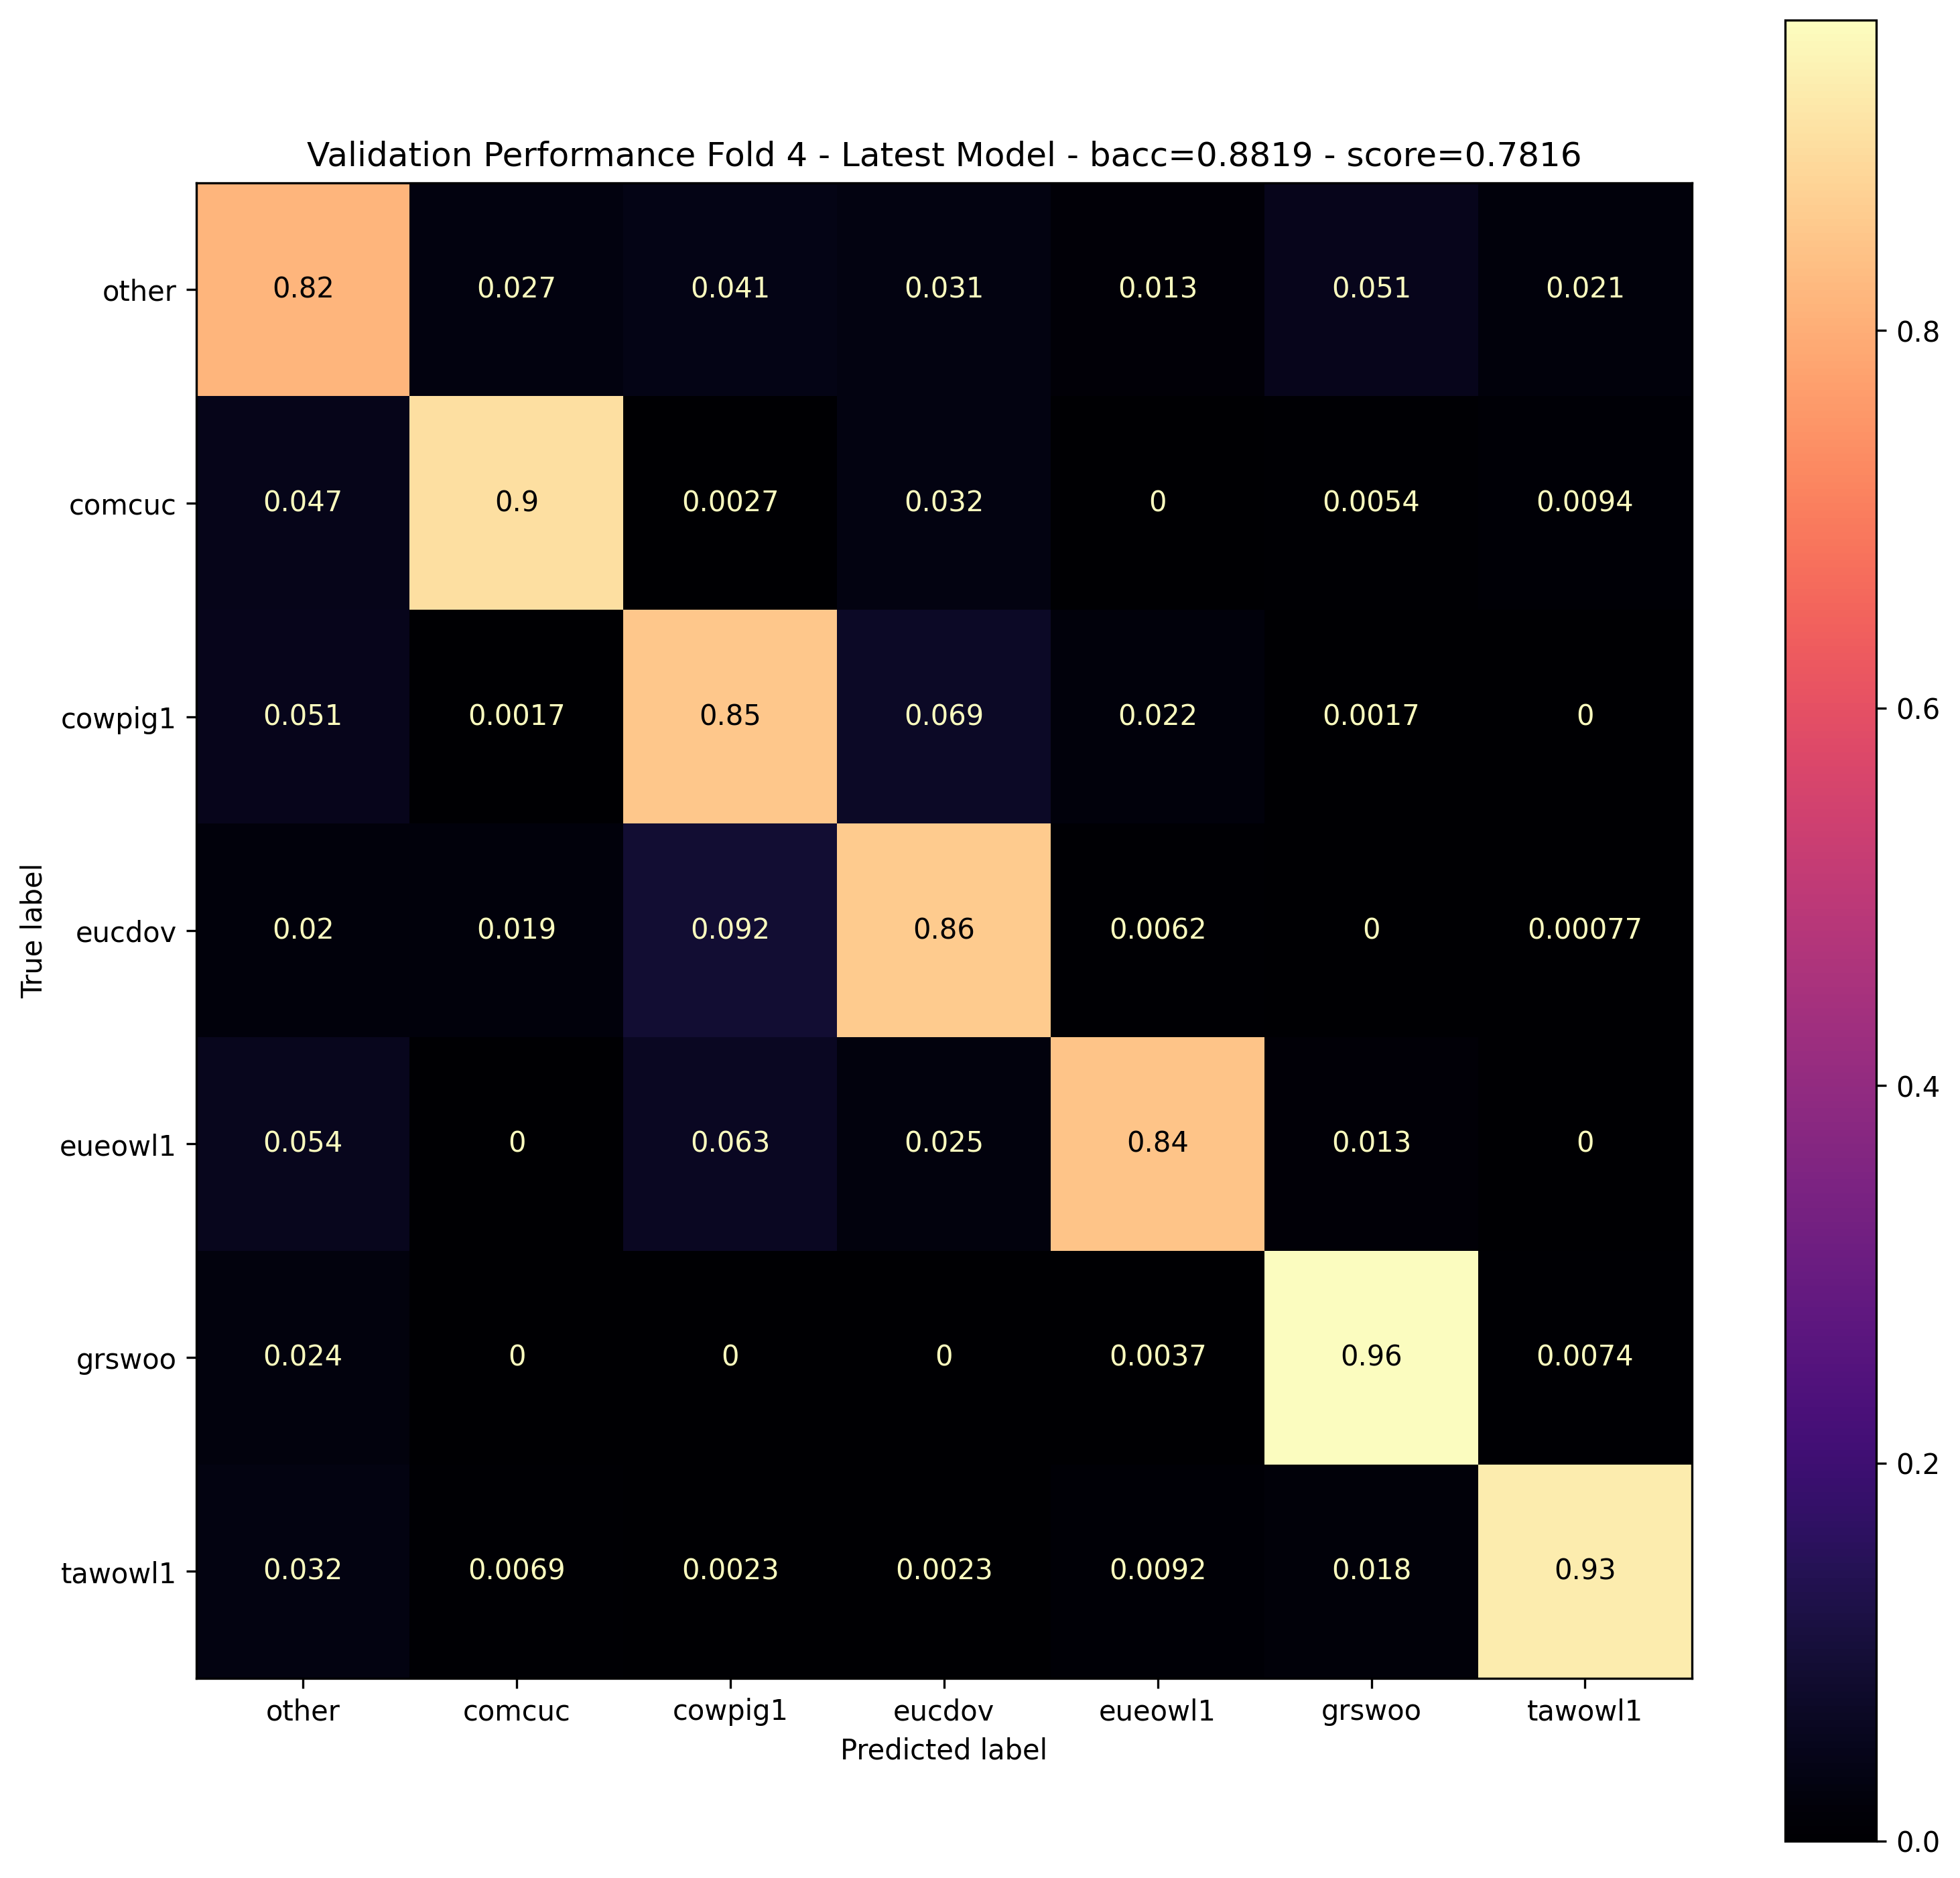

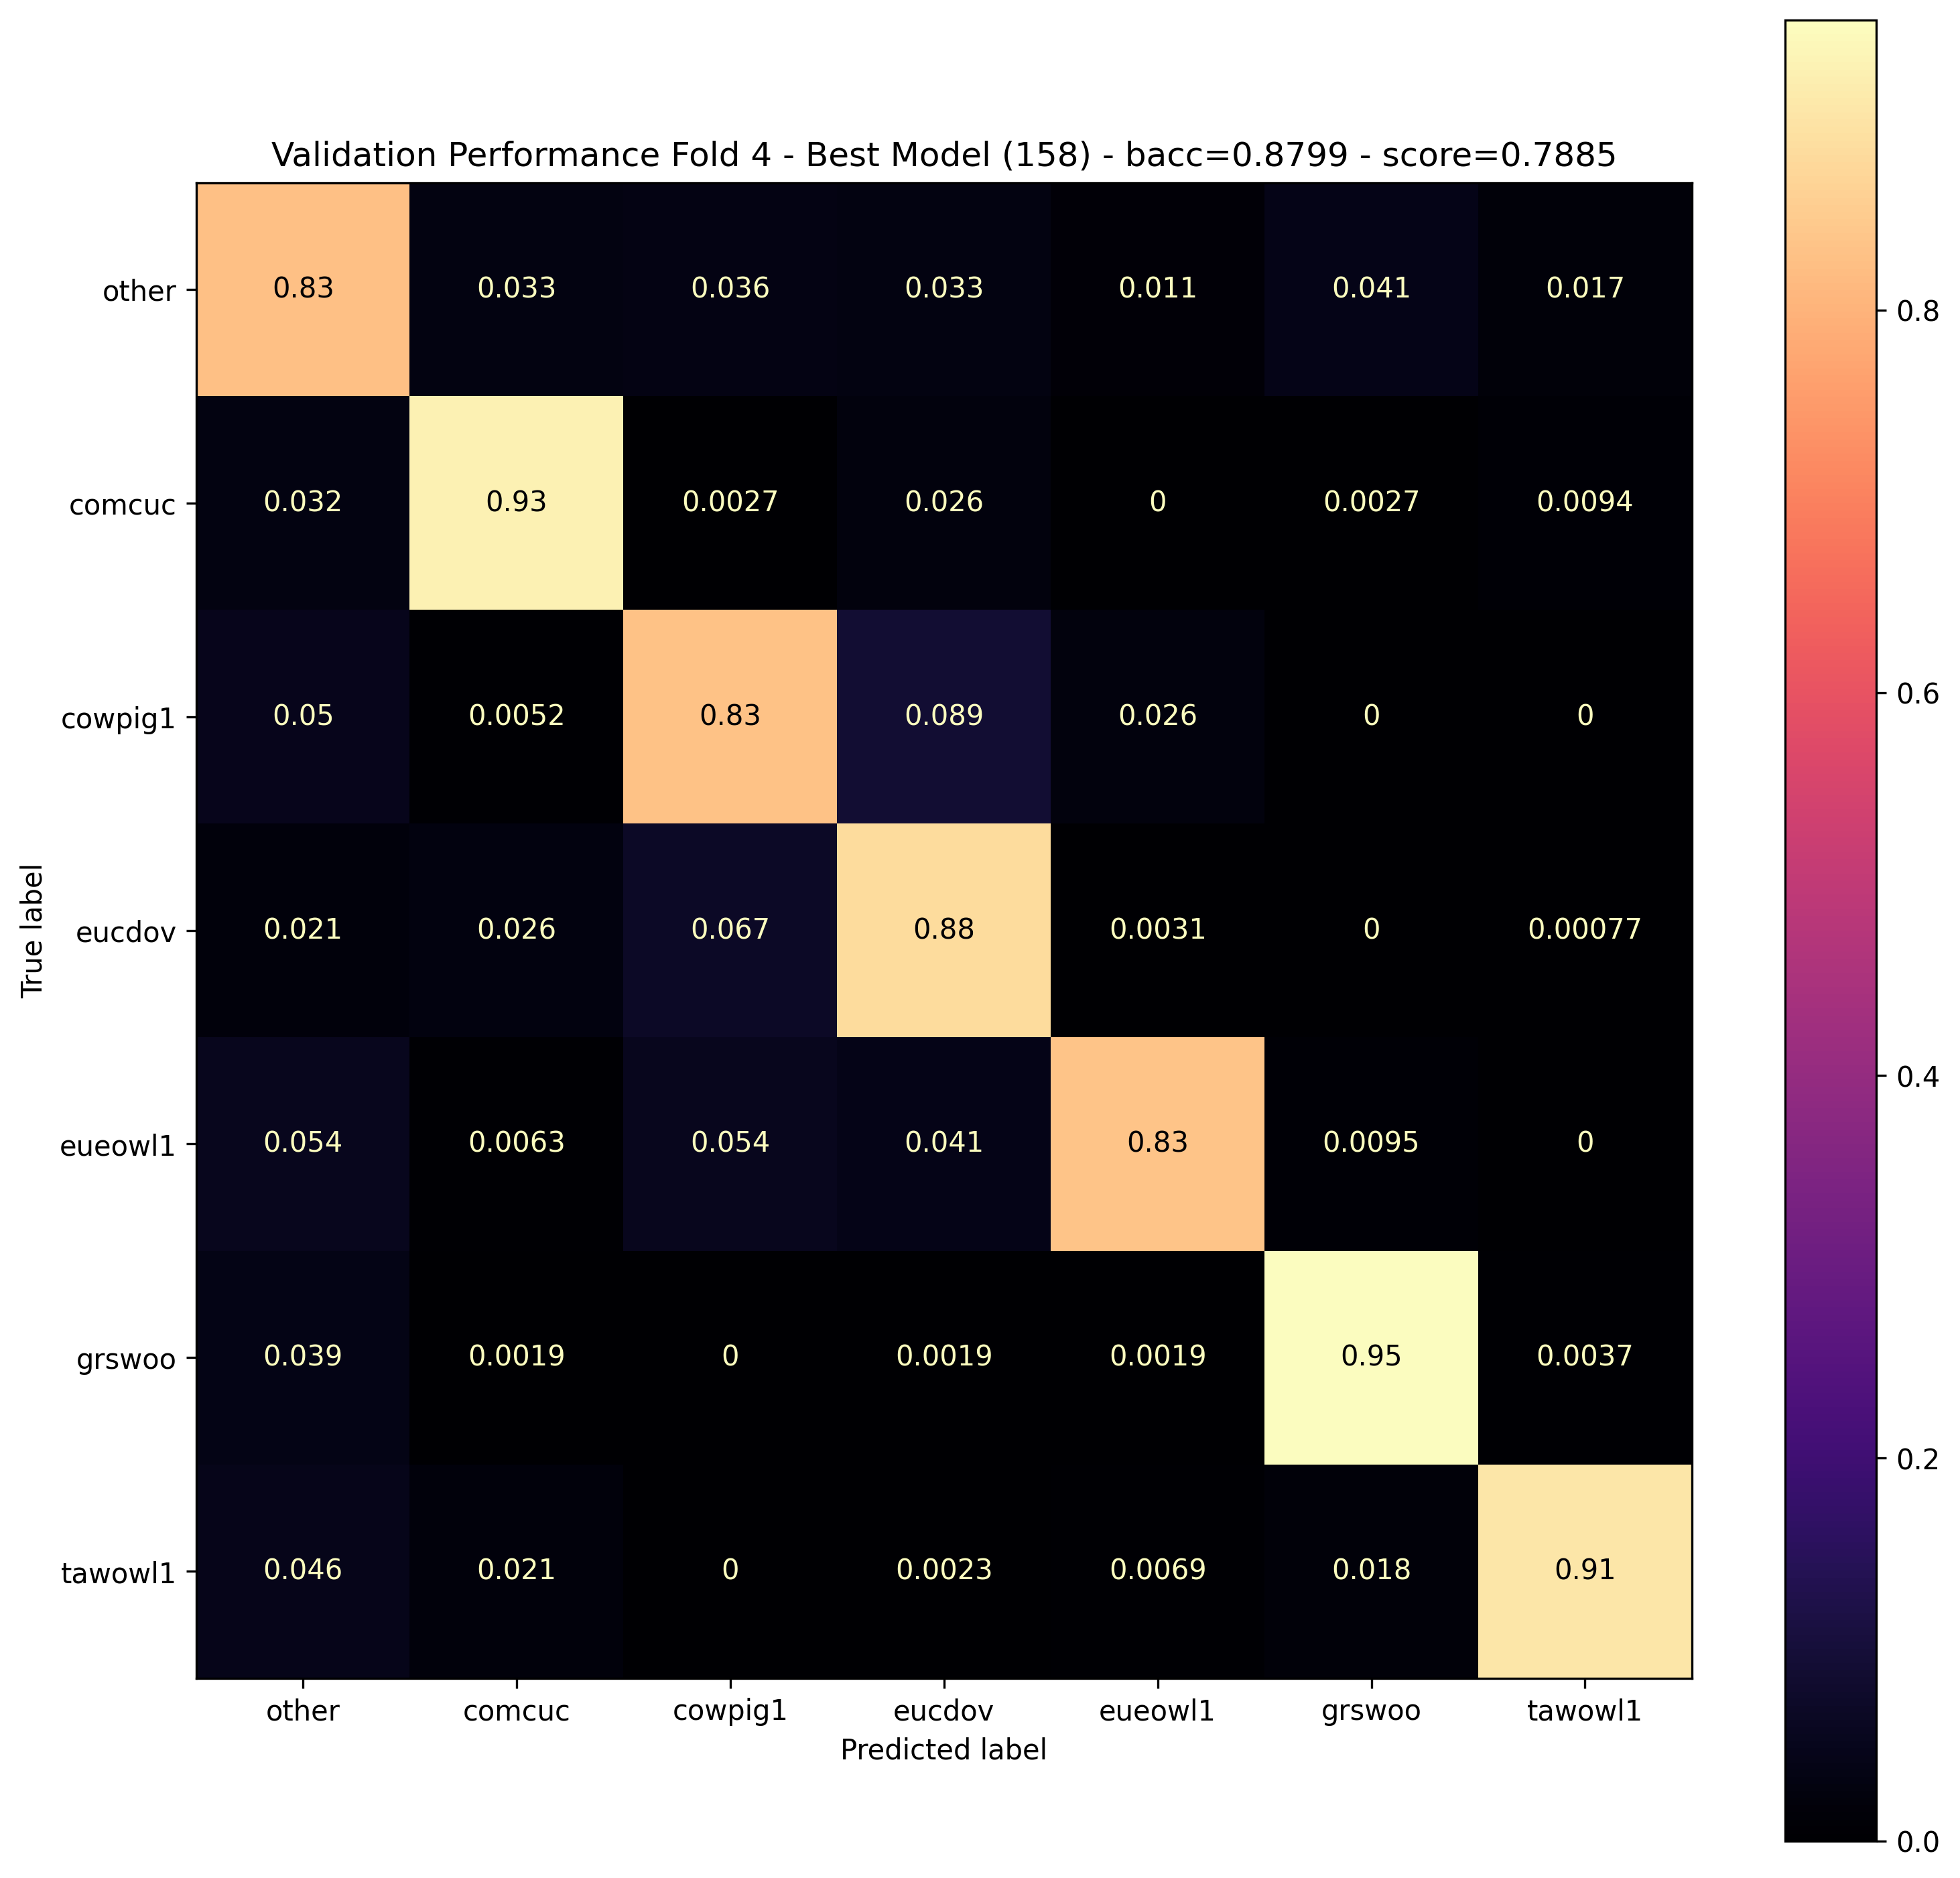

CV Folds:  62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                | 5/8 [04:06<02:27, 49.18s/it]

Saved model with scaler as "species_classifier cv2023-06-11_14.26 fold-4-best eval-score=0.7885"



Executing CV for fold 5
Training fold 5


#### Training ####
##################
AttentionClassifier with 62523 parameters, in_fnn: 45900, attention_stack: 14640, out_fnn: 1983
##################

train label counts = [74768,  5033,  7810,  7102,  2089,  4491,  3707]
eval label counts  = [10590,   800,  1144,  1096,   235,   620,   515]

loss weights                    = [ 0.50, 14.86,  6.38, 10.53, 35.79, 16.65, 20.17]
eval loss weights (theoretical) = [ 0.50, 13.24,  6.17,  9.66, 45.06, 17.08, 20.56]


Training Epoch   1/175: lr = 1.00E-03, epoch =     1, avg_loss = 0.000208, num_samples = 105000, num_correct = 25387, acc = 0.241781, bacc = 0.142501, score = -0.249917
Evaluation Epoch   1/175: epoch =     1, avg_loss = 0.000248, num_samples = 15000, num_correct =  1083, acc = 0.072200, bacc = 0.144251, score = -0.276890
Training Epoch   2/175: lr = 1.00E-03, epoch =     2, avg_loss = 0.

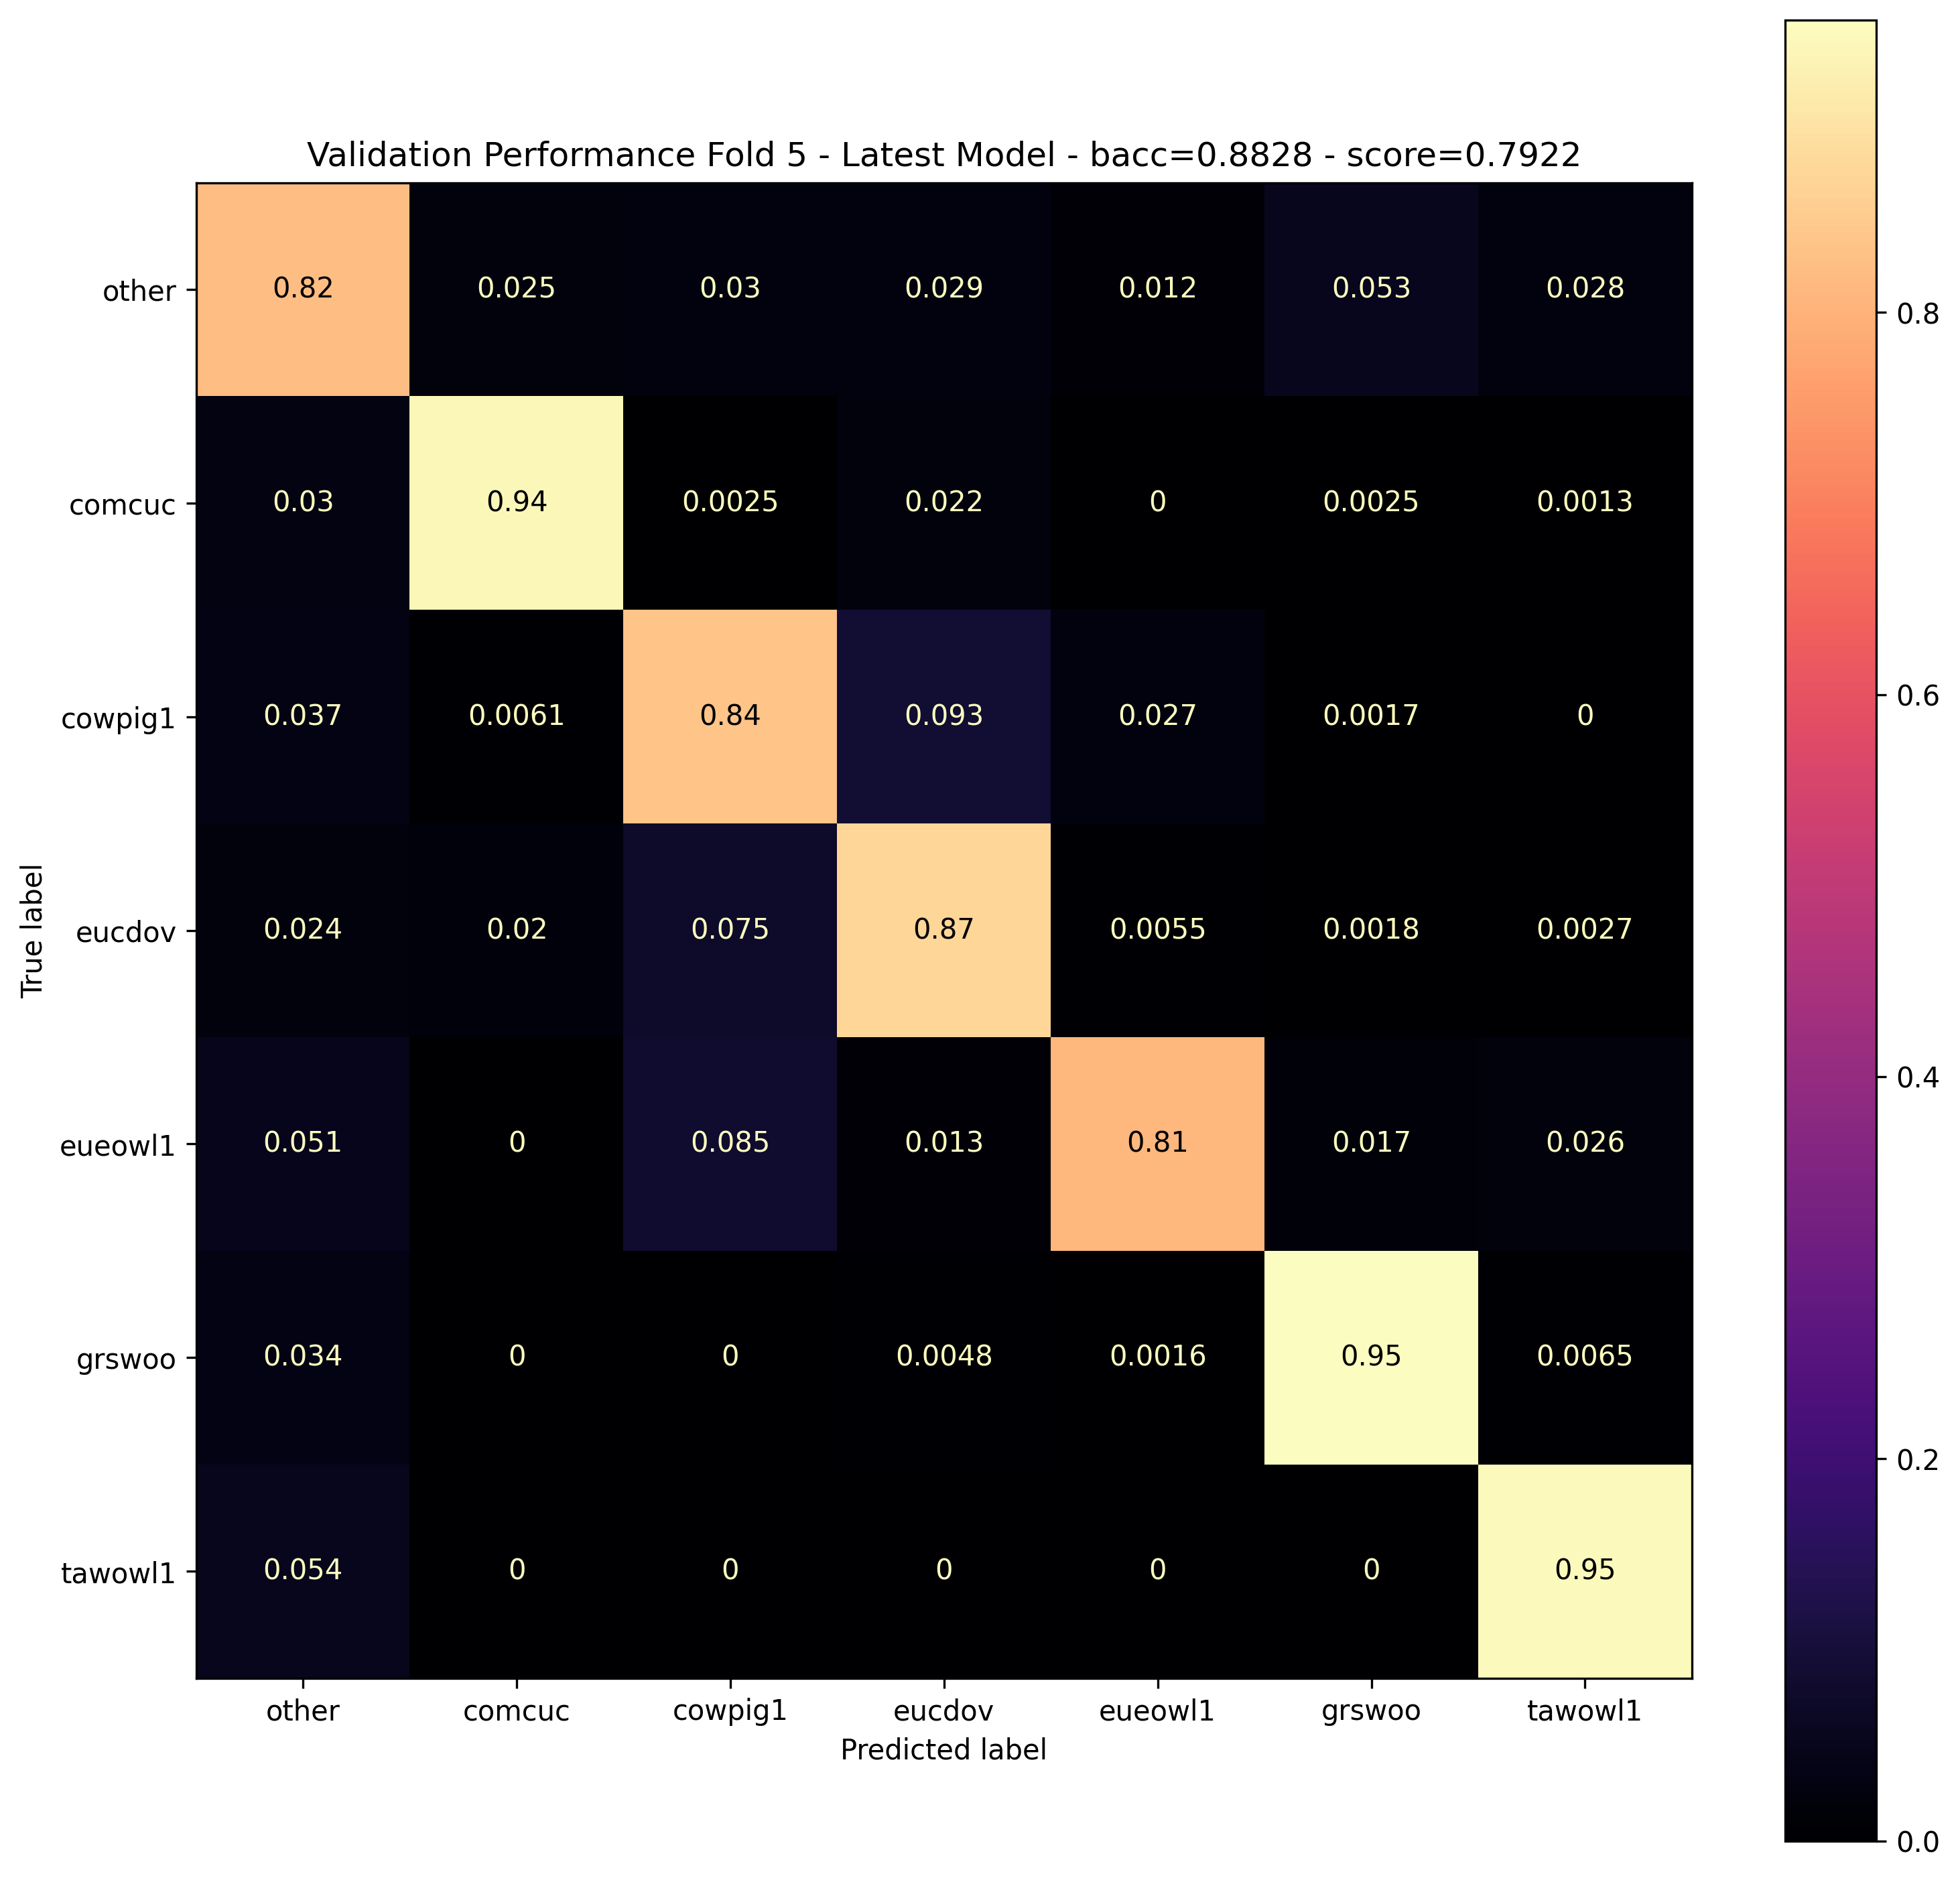

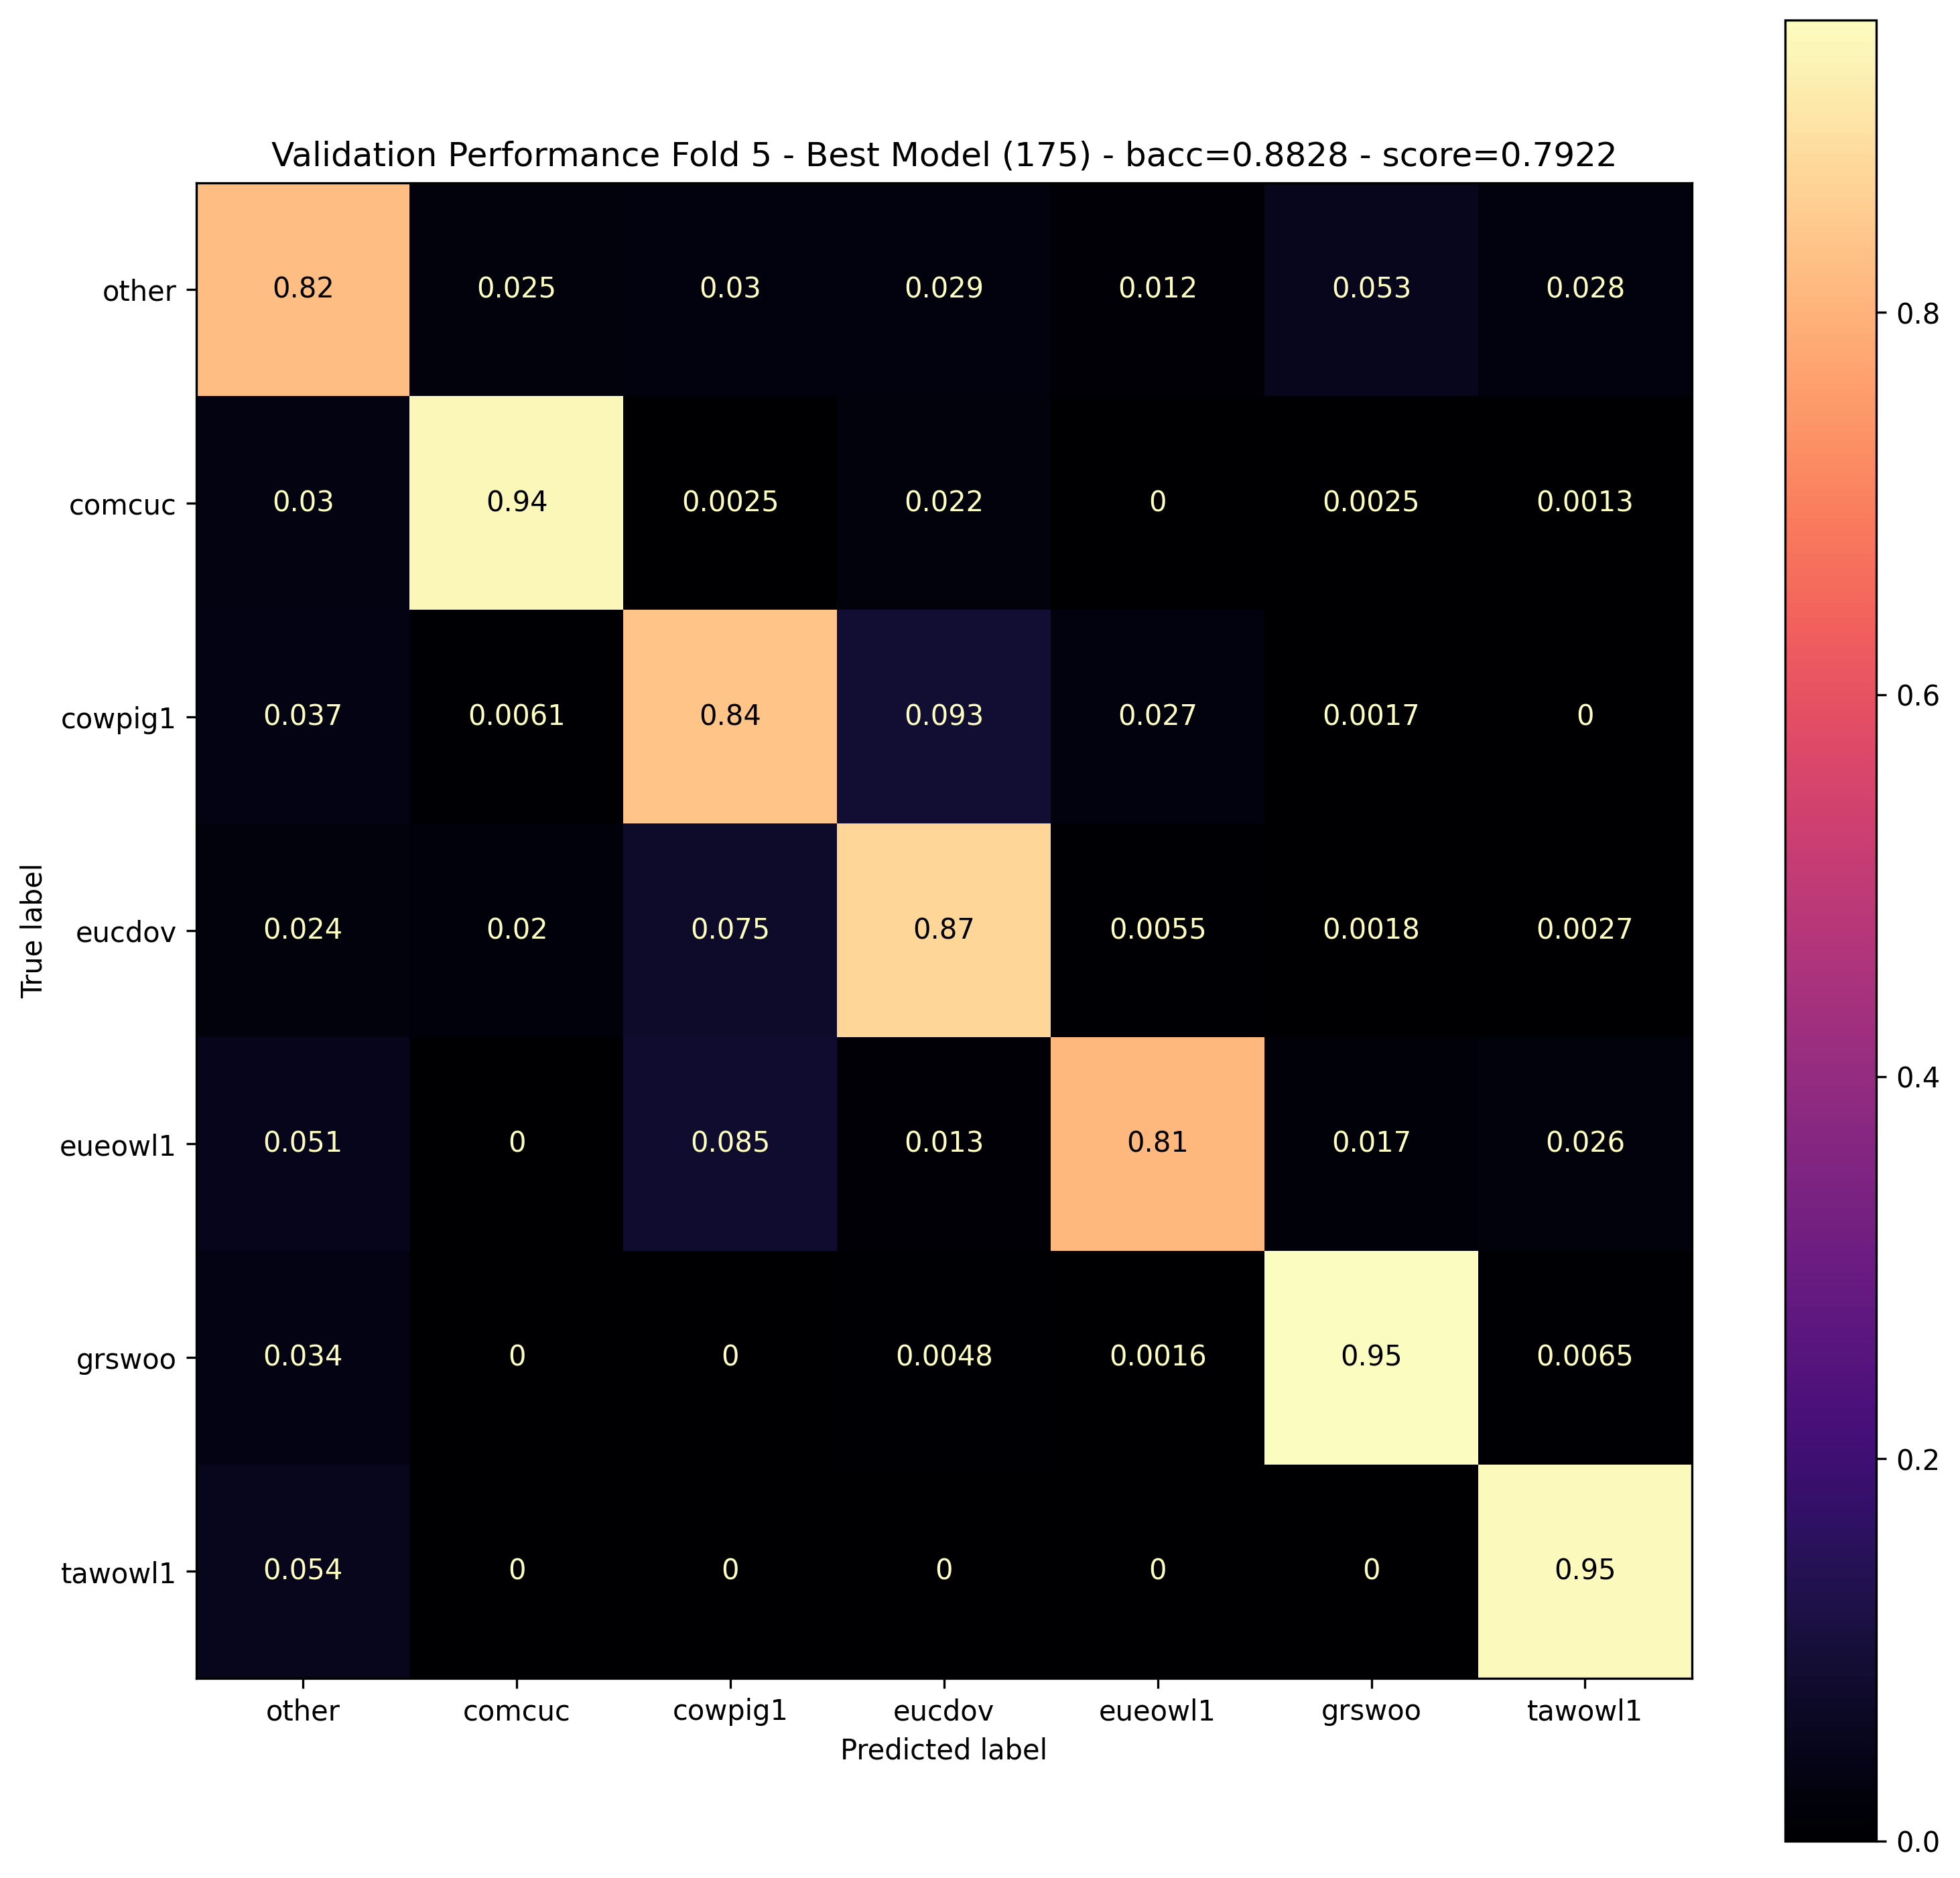

CV Folds:  75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 6/8 [04:56<01:38, 49.30s/it]

Saved model with scaler as "species_classifier cv2023-06-11_14.26 fold-5-best eval-score=0.7922"



Executing CV for fold 6
Training fold 6


#### Training ####
##################
AttentionClassifier with 62523 parameters, in_fnn: 45900, attention_stack: 14640, out_fnn: 1983
##################

train label counts = [74712,  4979,  7898,  7221,  2044,  4413,  3733]
eval label counts  = [10646,   854,  1056,   977,   280,   698,   489]

loss weights                    = [ 0.50, 15.01,  6.31, 10.35, 36.55, 16.93, 20.01]
eval loss weights (theoretical) = [ 0.50, 12.47,  6.72, 10.90, 38.02, 15.25, 21.77]


Training Epoch   1/175: lr = 1.00E-03, epoch =     1, avg_loss = 0.000204, num_samples = 105000, num_correct =  6315, acc = 0.060143, bacc = 0.142758, score = -0.324031
Evaluation Epoch   1/175: epoch =     1, avg_loss = 0.000288, num_samples = 15000, num_correct =   890, acc = 0.059333, bacc = 0.150241, score = -0.324499
Training Epoch   2/175: lr = 1.00E-03, epoch =     2, avg_loss = 0.

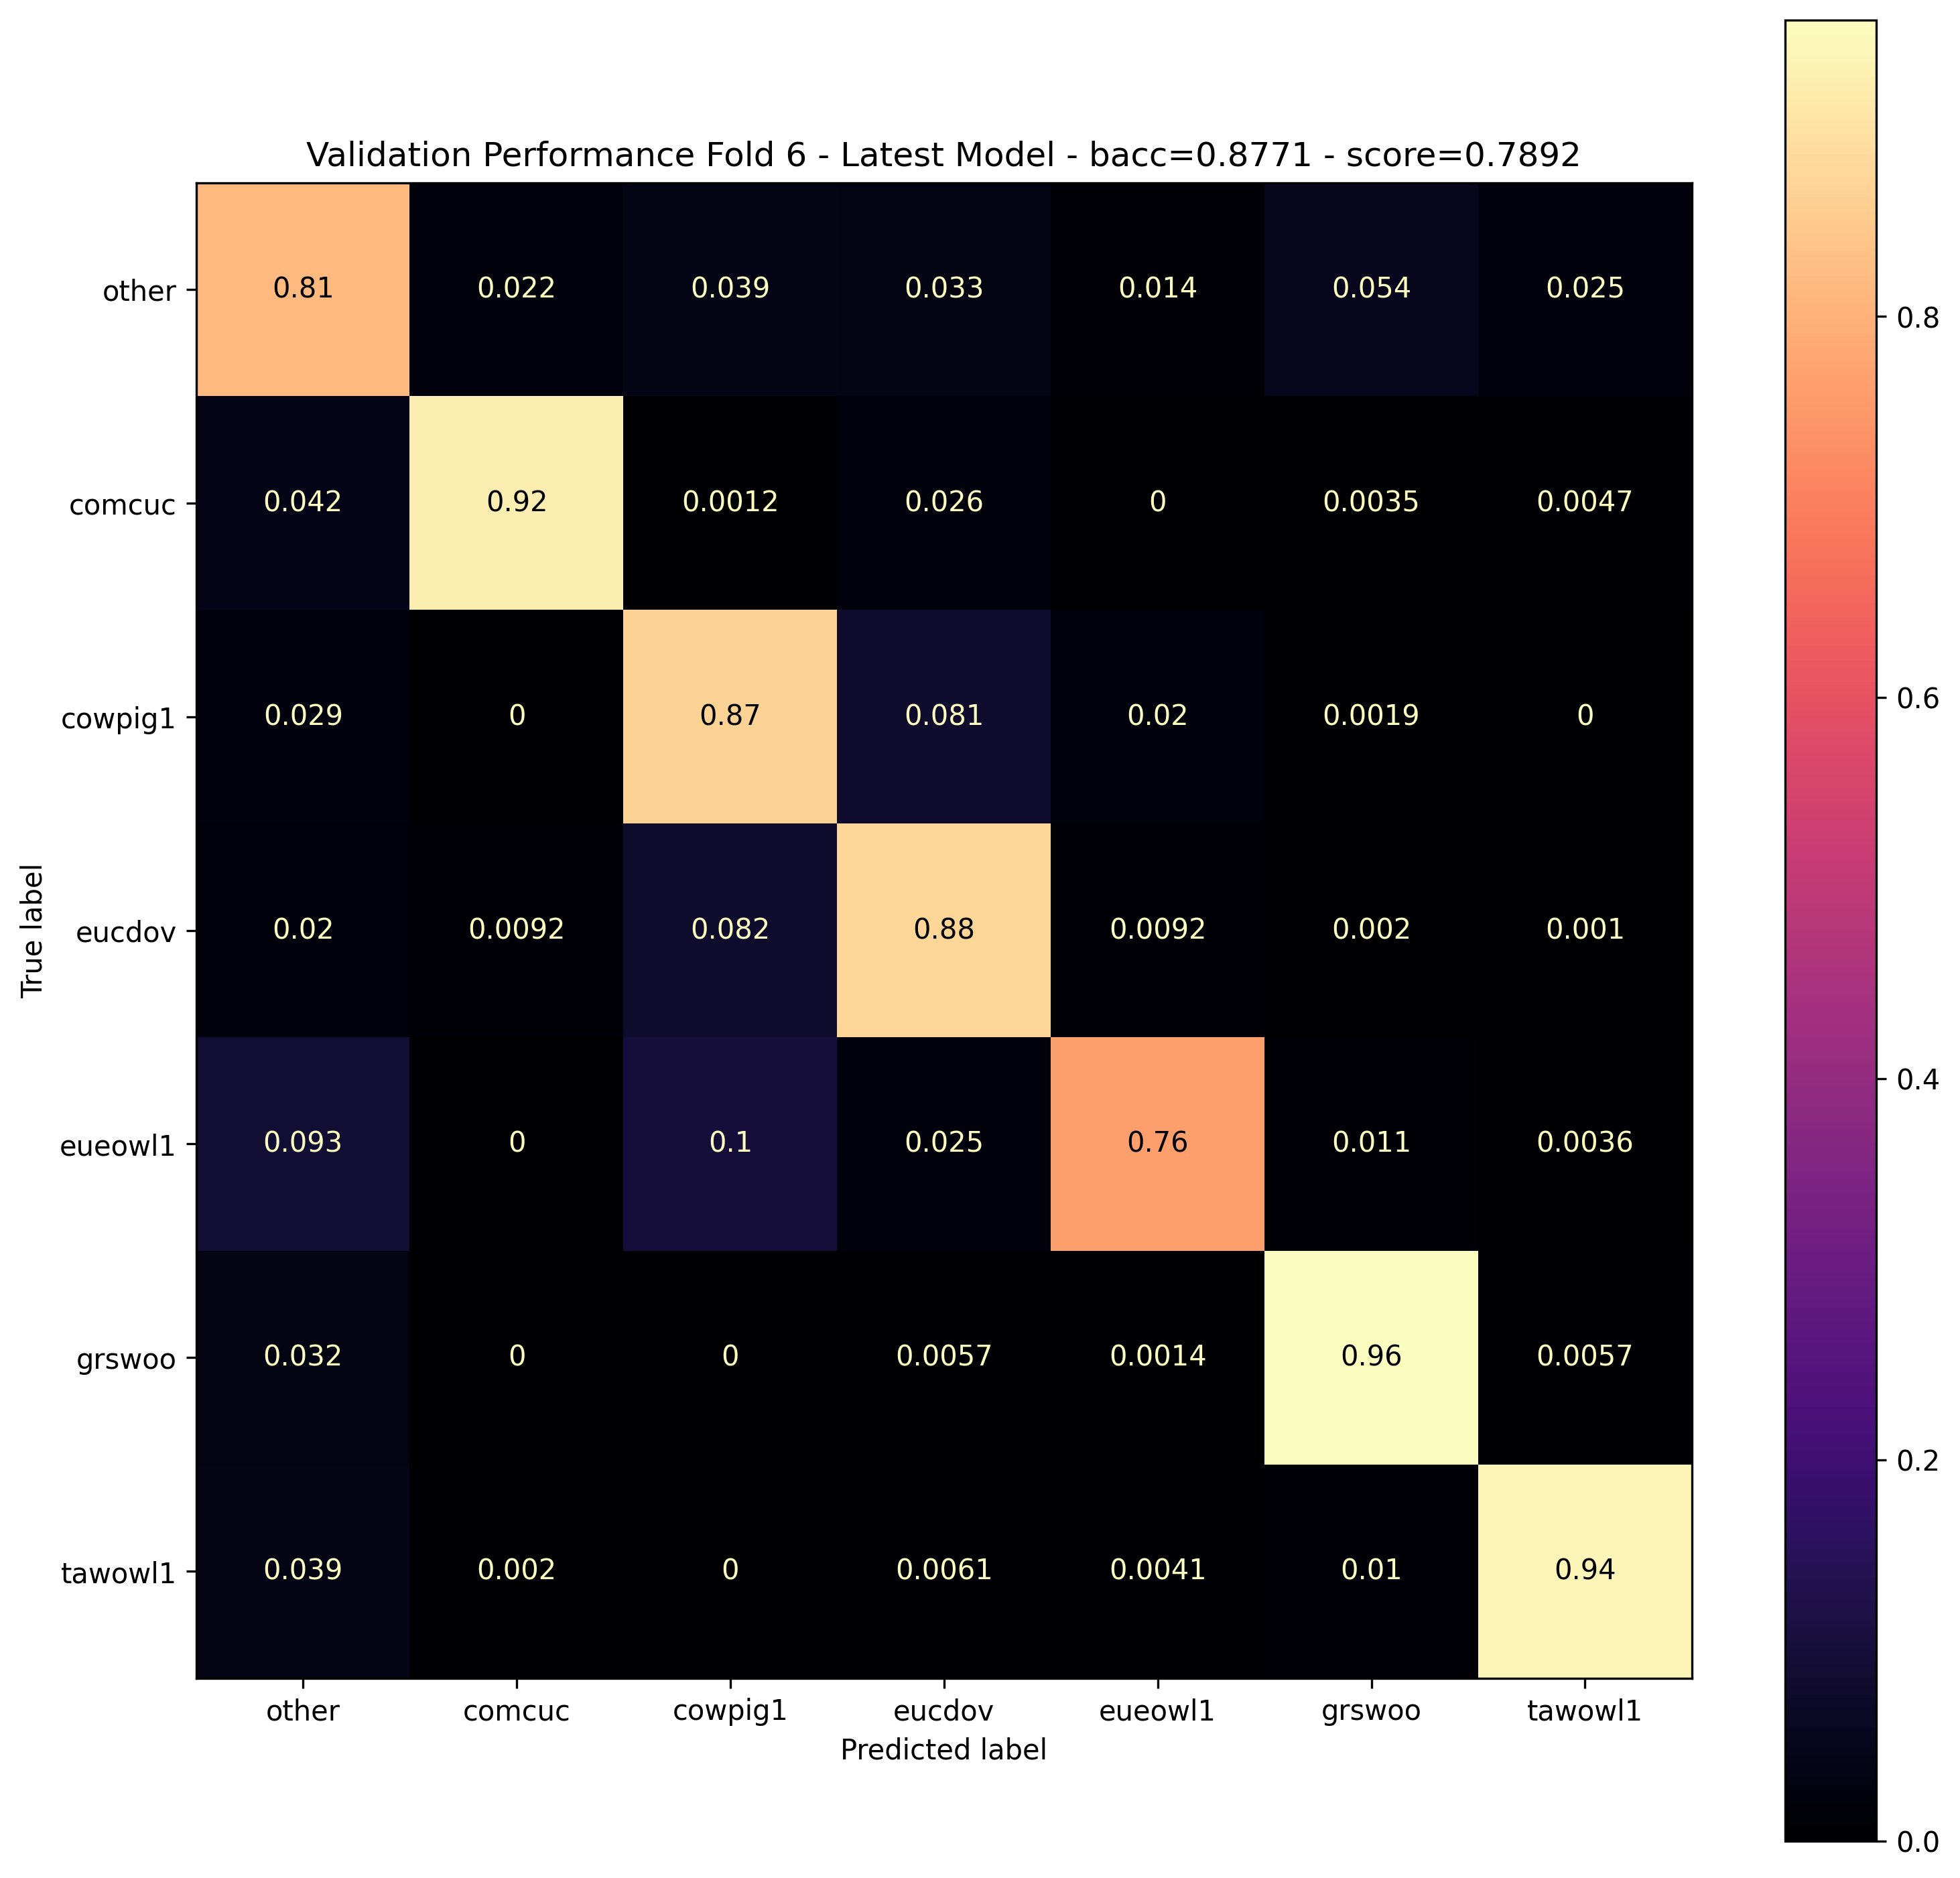

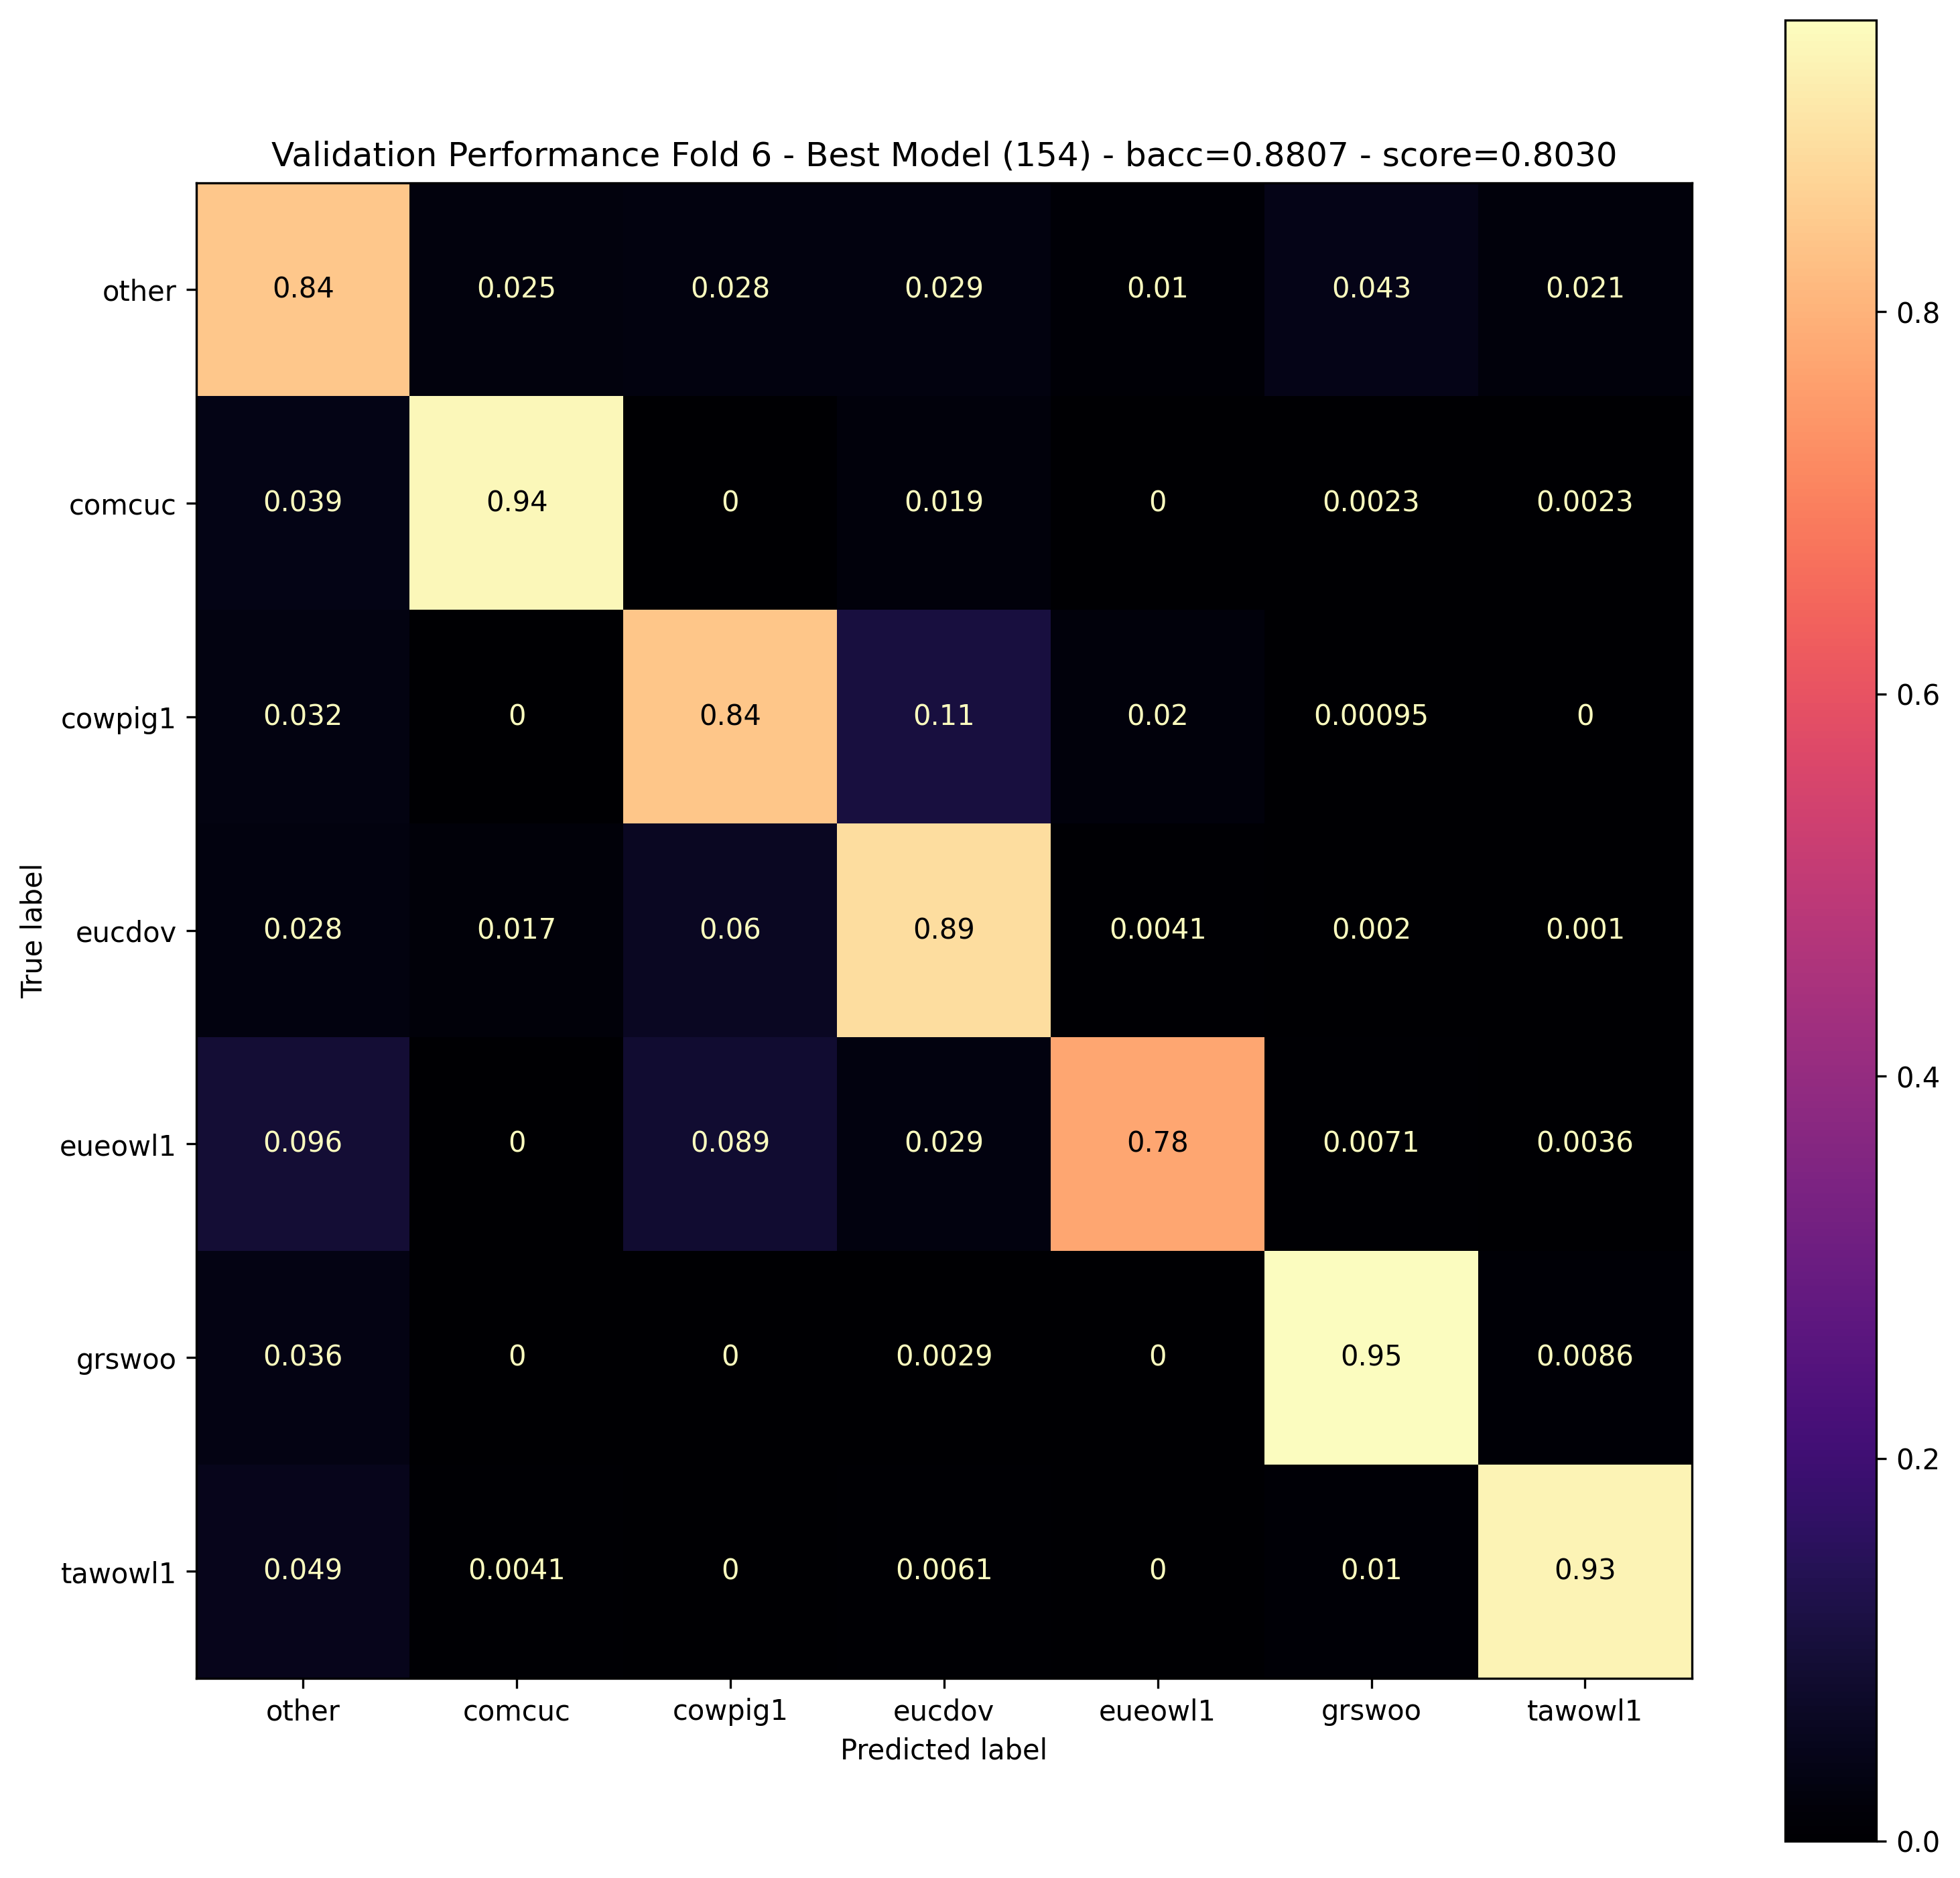

CV Folds:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 7/8 [05:45<00:49, 49.20s/it]

Saved model with scaler as "species_classifier cv2023-06-11_14.26 fold-6-best eval-score=0.8030"



Executing CV for fold 7
Training fold 7


#### Training ####
##################
AttentionClassifier with 62523 parameters, in_fnn: 45900, attention_stack: 14640, out_fnn: 1983
##################

train label counts = [74658,  5710,  7433,  7450,  2050,  4242,  3457]
eval label counts  = [10700,   123,  1521,   748,   274,   869,   765]

loss weights                    = [ 0.50, 13.07,  6.70, 10.02, 36.42, 17.60, 21.60]
eval loss weights (theoretical) = [ 0.50, 86.99,  4.69, 14.30, 39.05, 12.31, 13.99]


Training Epoch   1/175: lr = 1.00E-03, epoch =     1, avg_loss = 0.000204, num_samples = 105000, num_correct =  3126, acc = 0.029771, bacc = 0.143269, score = -0.436557
Evaluation Epoch   1/175: epoch =     1, avg_loss = 0.000263, num_samples = 15000, num_correct =   274, acc = 0.018267, bacc = 0.142857, score = -0.469204
Training Epoch   2/175: lr = 1.00E-03, epoch =     2, avg_loss = 0.

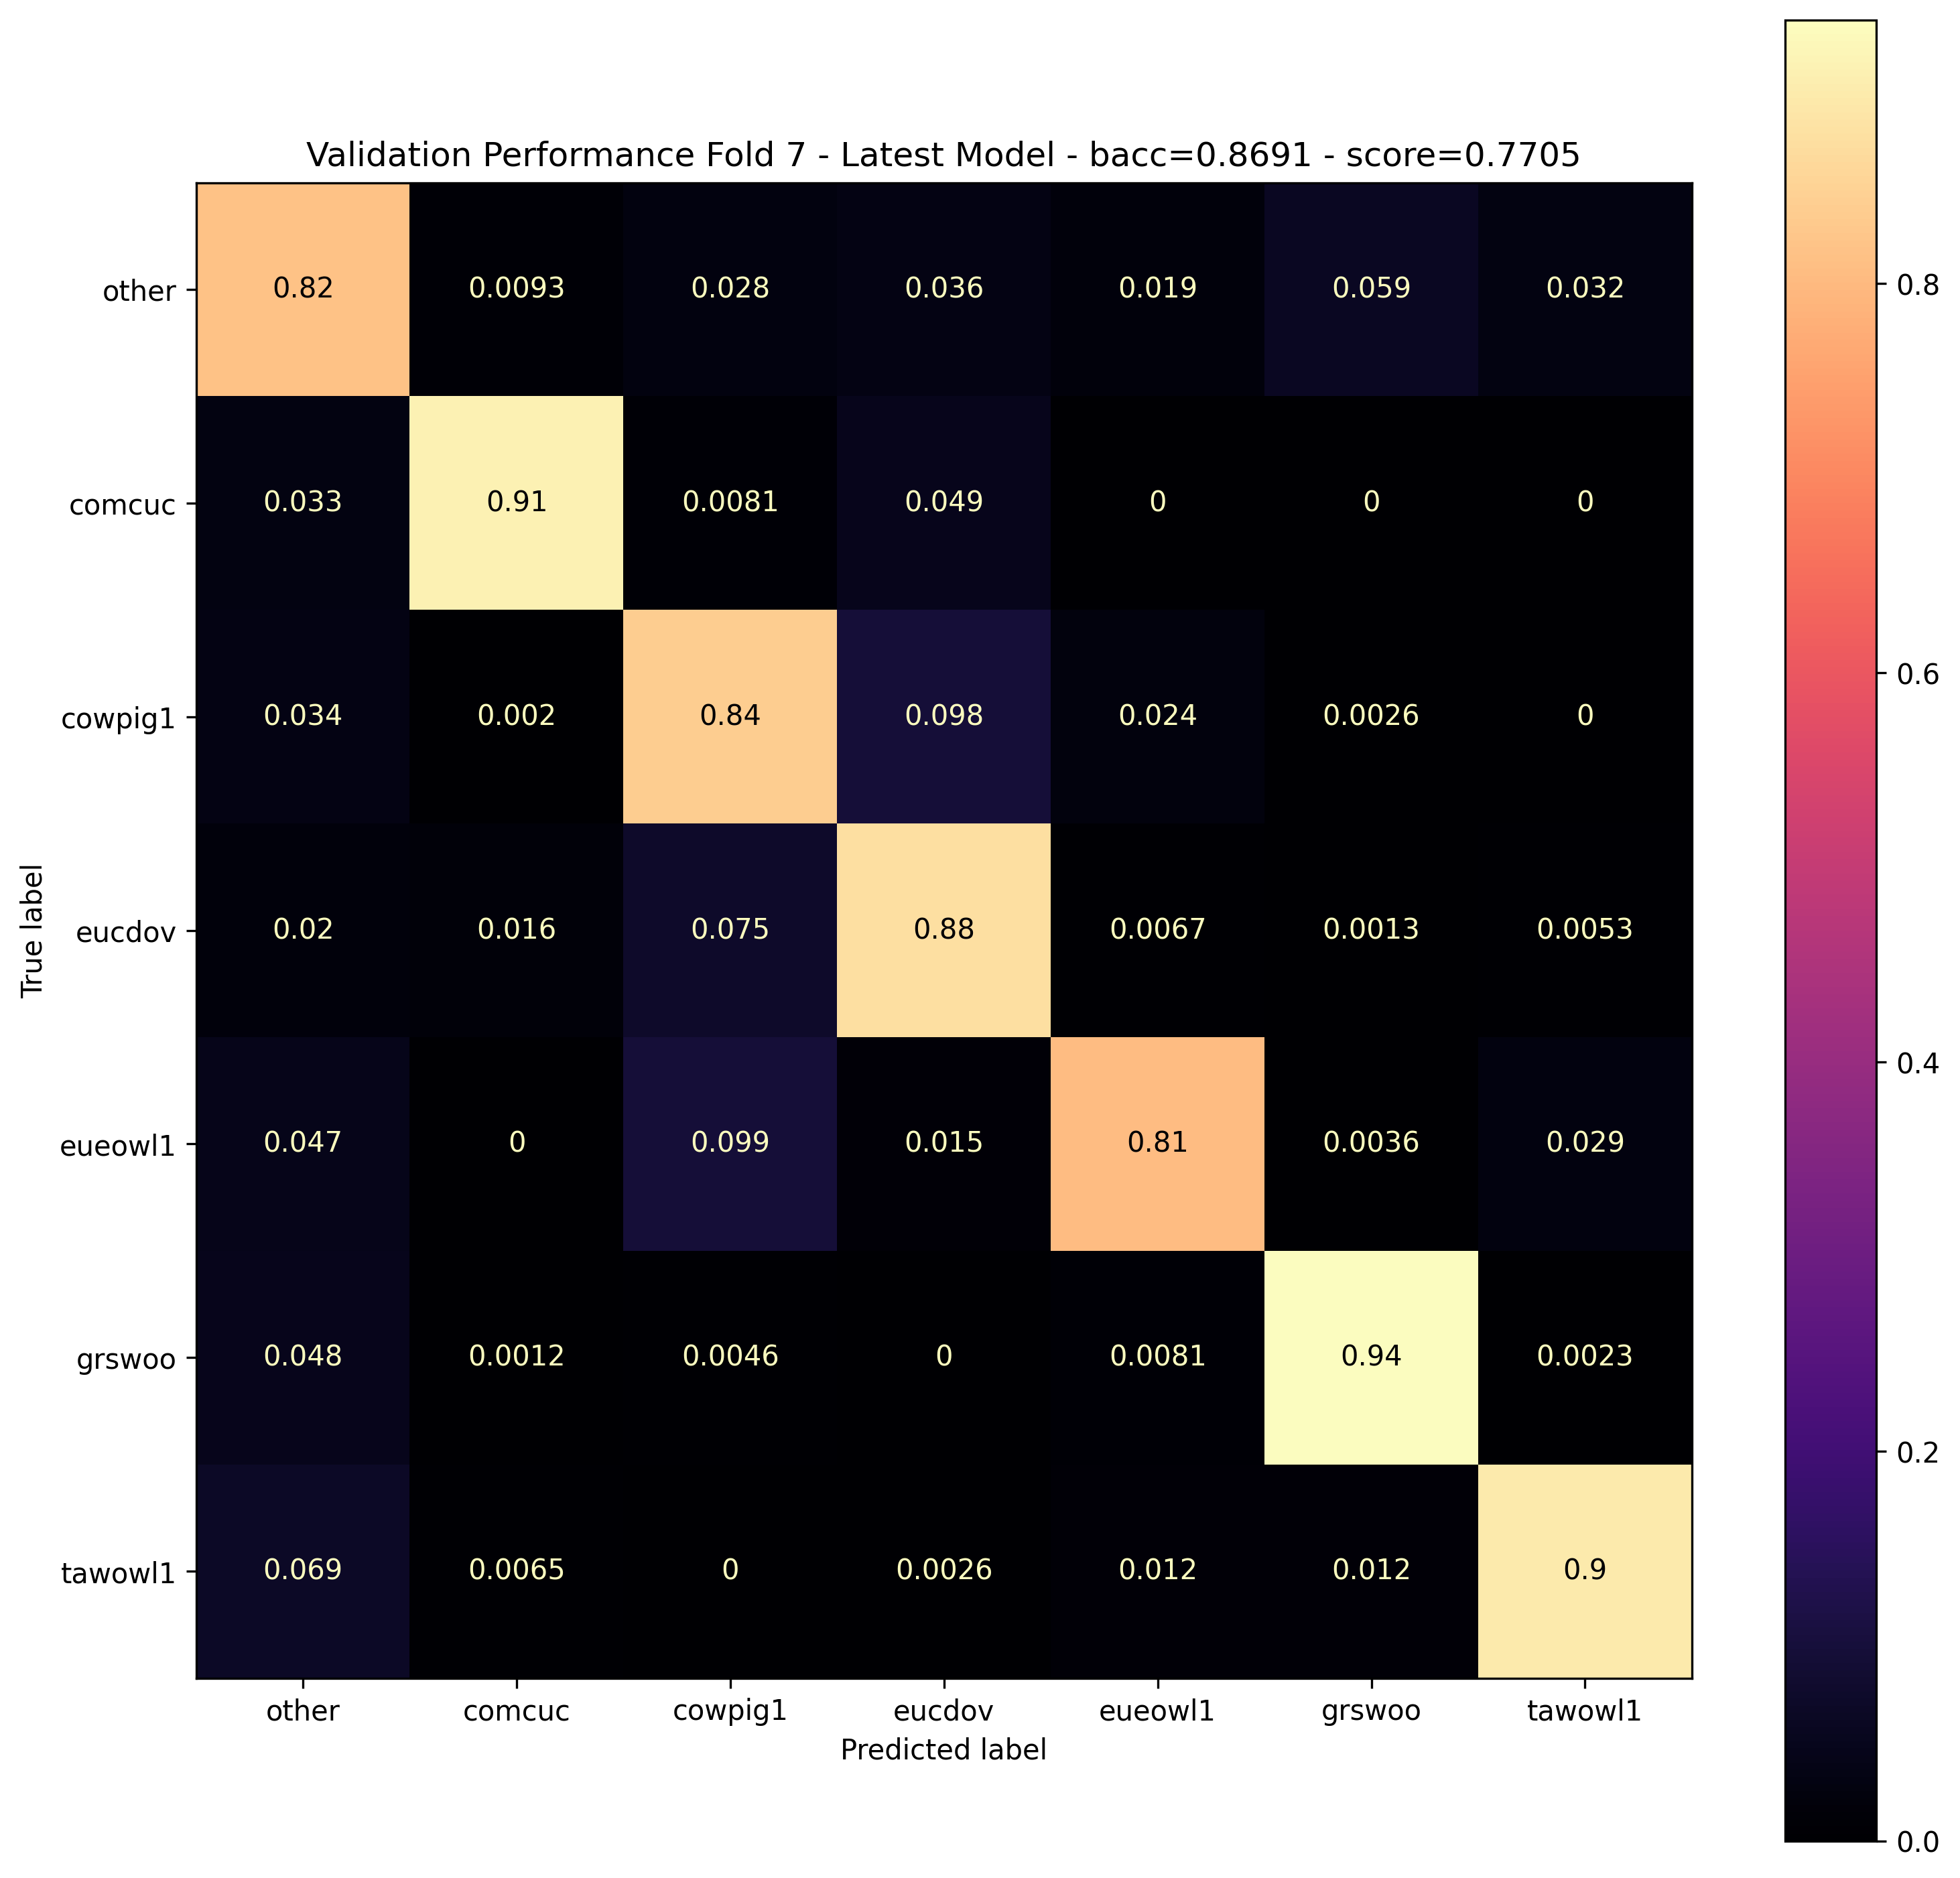

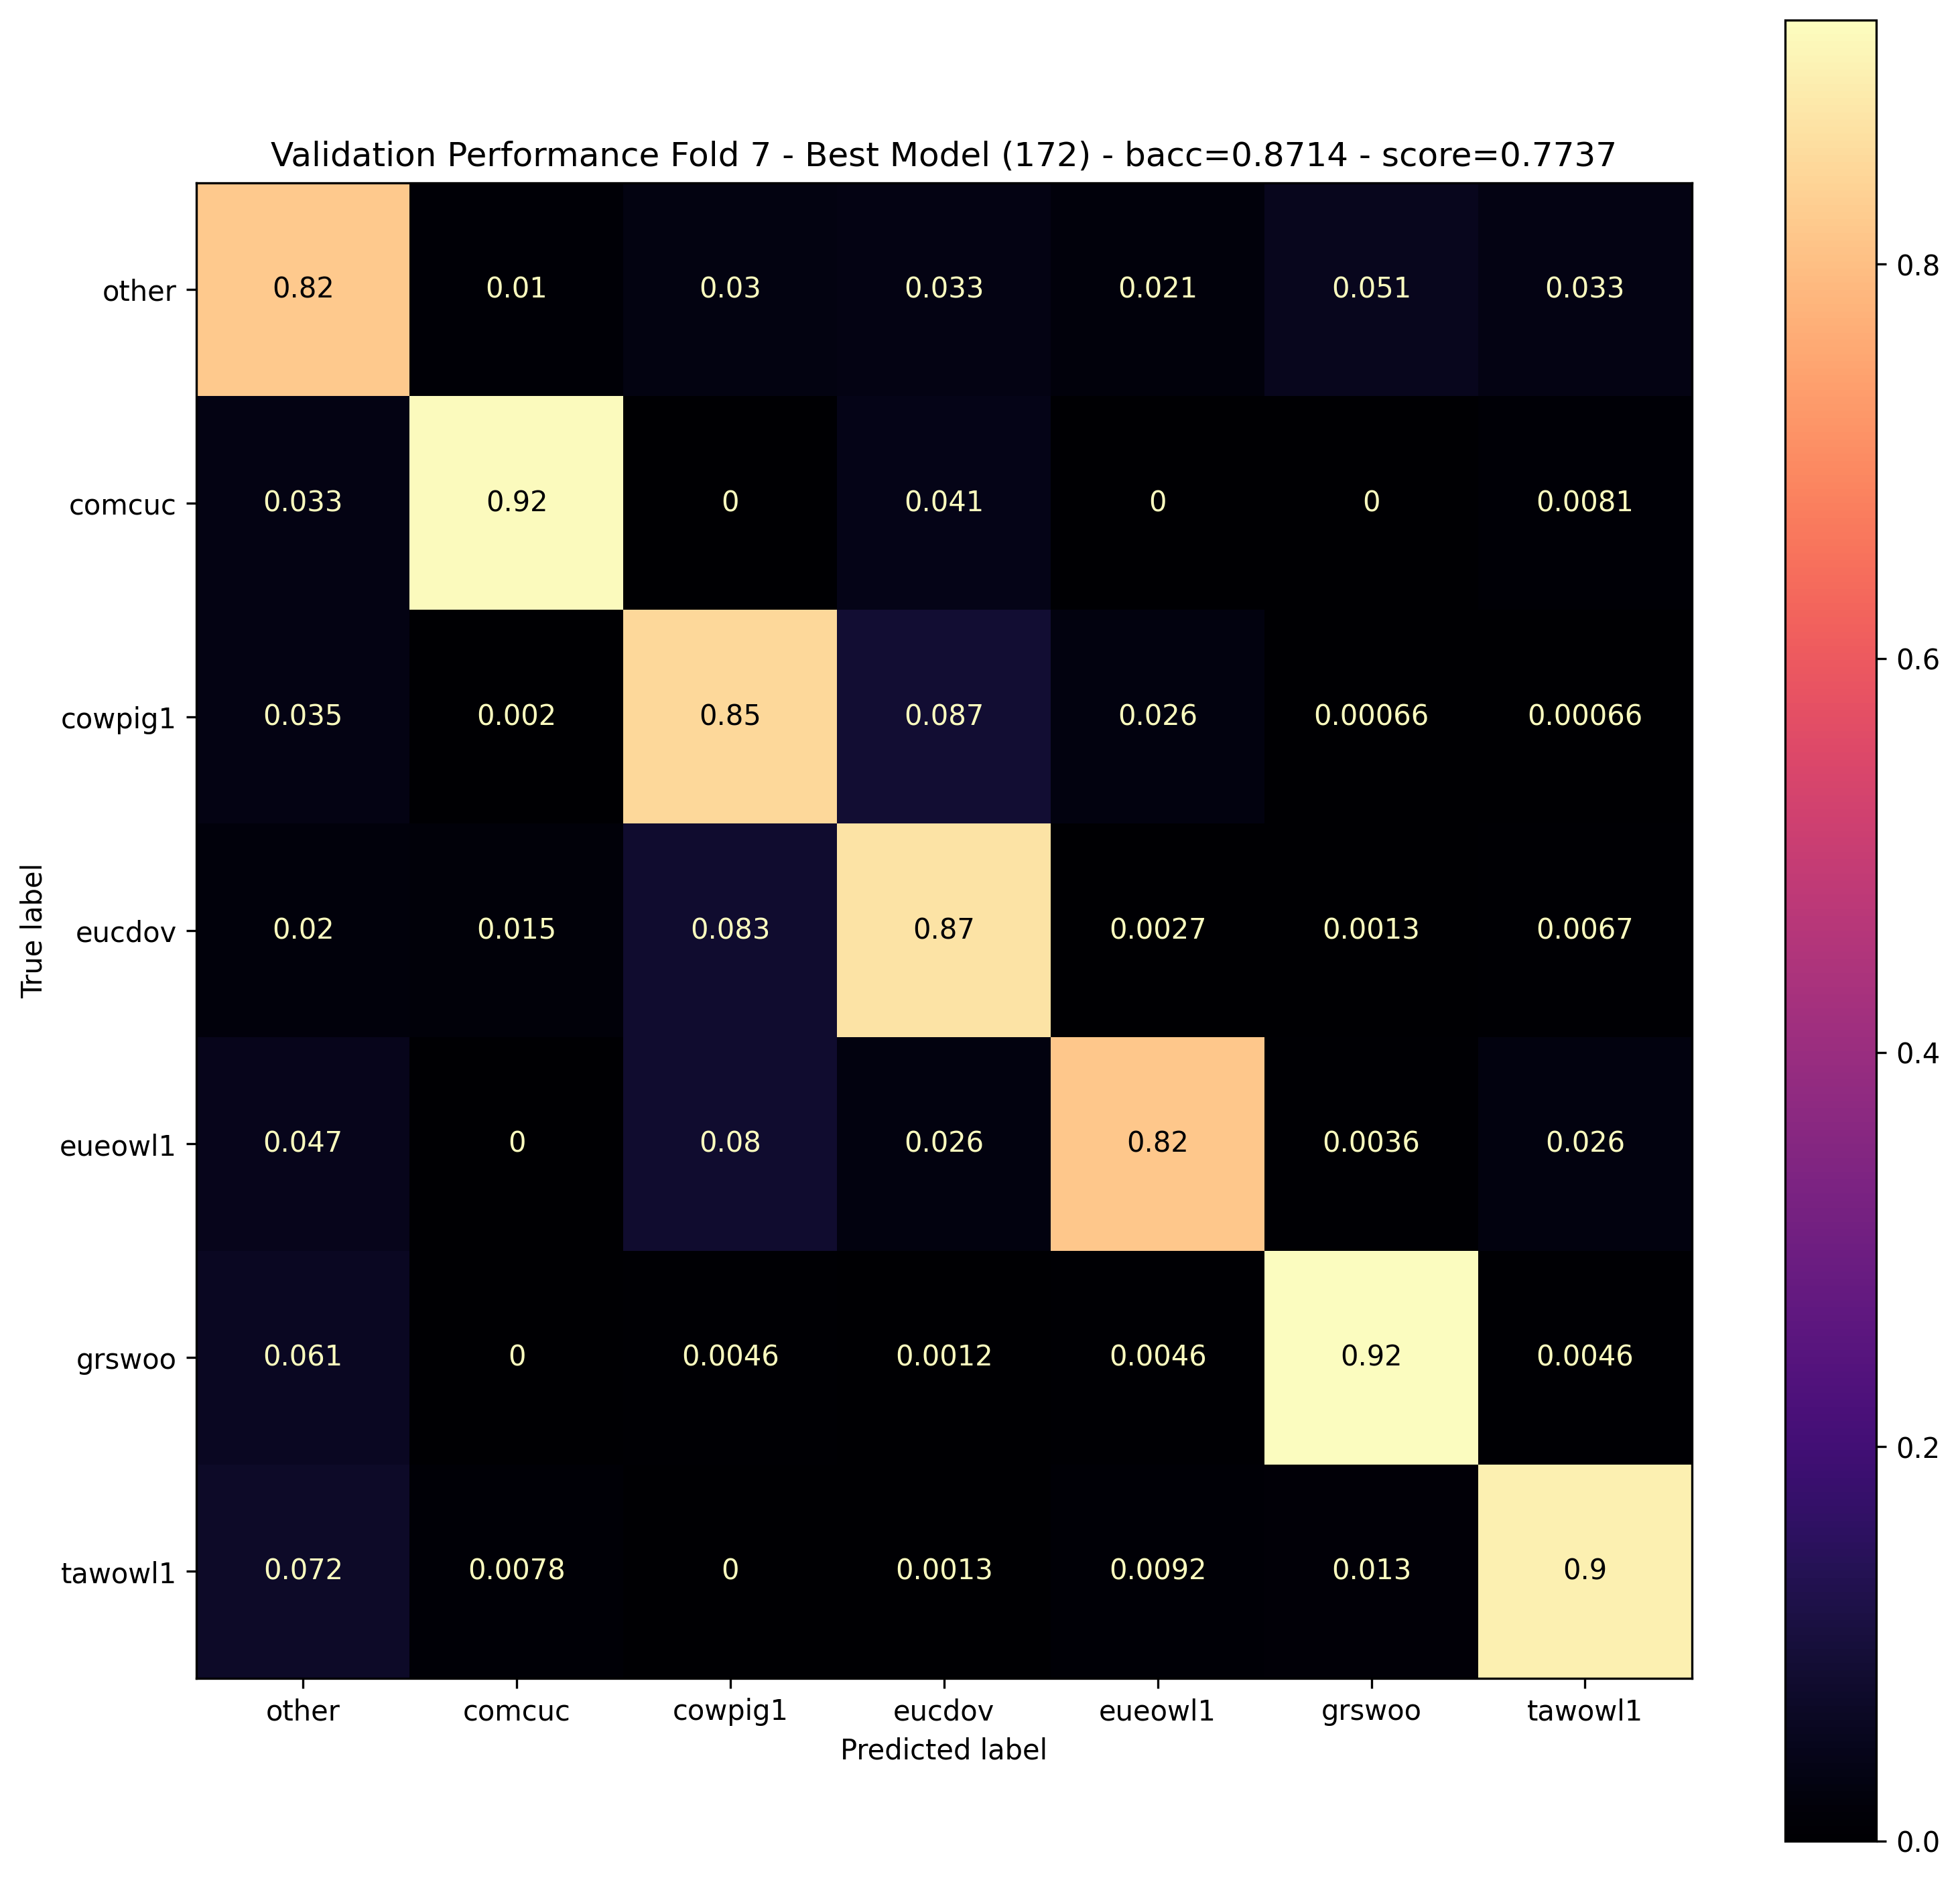

CV Folds: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [06:34<00:00, 49.26s/it]

Saved model with scaler as "species_classifier cv2023-06-11_14.26 fold-7-best eval-score=0.7737"


#################
#### Metrics ####
#################


cv_average_best_best_models_eval_metrics = epoch = 162.375000, avg_loss = 0.000078, num_samples = 15000.000000, num_correct = 12684.750000, acc = 0.845650, bacc = 0.879692, score = 0.789176 




In [51]:
set_random_seed(43)

cv_models_with_scalers, cv_folds_metrics, best_models_metrics = train_model_with_cv(
    lambda: AttentionClassifier(ac_hyper_parameters),
    training_hyper_parameters, 
    sequences_ds_train,
    sequences_ds_test,
    n_folds=8,
    device=device,
    save_models='best',
    model_saving_name='species_classifier',
)


## Metrics ##
print(
'''

#################
#### Metrics ####
#################

'''
)

cv_average_best_best_models_eval_metrics = calculate_average_metrics([m[1] for m in best_models_metrics])
print(f'{cv_average_best_best_models_eval_metrics = } \n\n')

if best_models_metrics[0][2] is not None:
    cv_average_best_best_models_test_metrics = calculate_average_metrics([m[2] for m in best_models_metrics])
    print(f'{cv_average_best_best_models_test_metrics = } \n\n')

cv_avg_epoch_train_metrics = calculate_average_metrics_per_epoch(cv_folds_metrics)

rows = []
for fold_nr, fold_metrics in enumerate(cv_folds_metrics):
    for epoch_nr, (train_metrics, eval_metrics) in enumerate(fold_metrics):
        rows.append({
            'cv_fold': fold_nr,
            'epoch': epoch_nr,
            'type': 'CV Train BACC',
            'bacc': train_metrics.bacc,
        })
        if eval_metrics is not None:
            rows.append({
                'cv_fold': fold_nr,
                'epoch': epoch_nr,
                'type': 'CV Eval BACC',
                'bacc': eval_metrics.bacc,
            })

cv_metrics_df = pd.DataFrame(rows)

# Plots

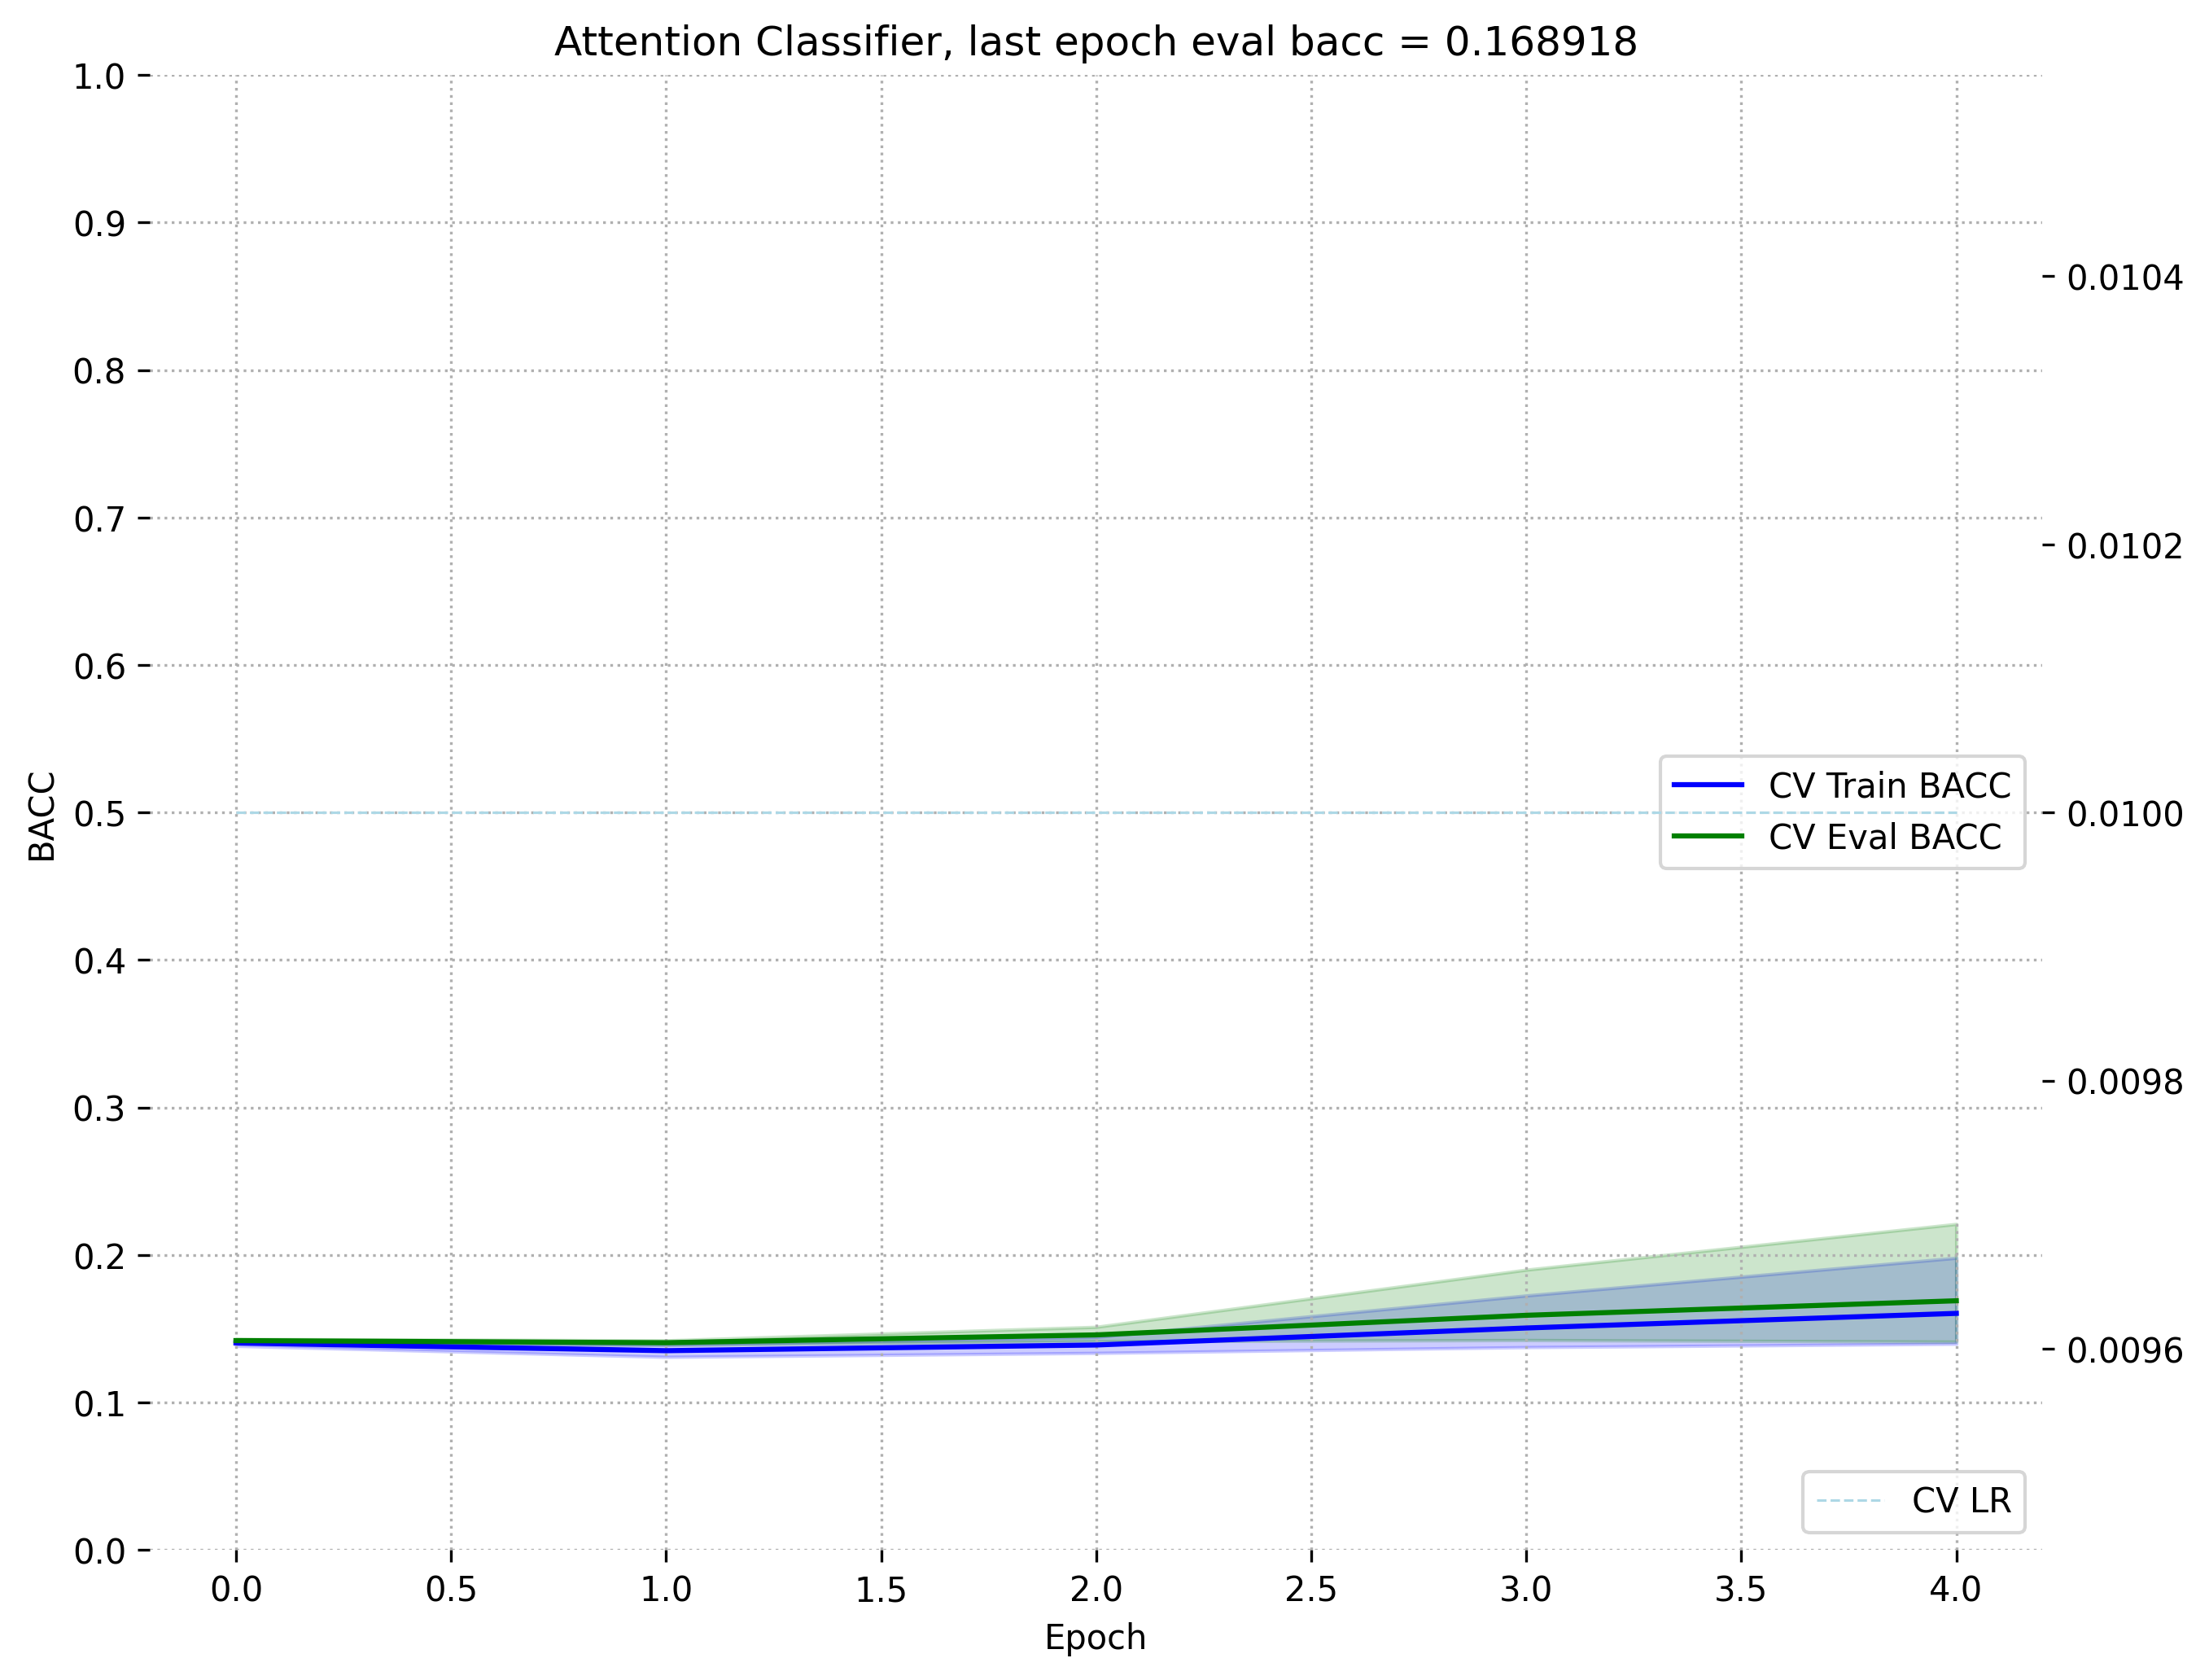

In [26]:
def create_lrs_over_epochs(training_hyper_parameters: TrainingHyperParameters) -> list[float]:
    lrs: list[float] = []
    
    lr = training_hyper_parameters.lr
    for epoch_nr in range(training_hyper_parameters.num_epochs):
        if epoch_nr in training_hyper_parameters.lr_scheduler_milestones:
            lr *= training_hyper_parameters.lr_scheduler_gamma
        lrs.append(lr)
    return lrs
    

def plot_baccs_over_epochs(title: str):
    fig, ax = plt.subplots(1, 1, figsize=(10, 8), dpi=300)
    
    cv_epoch_range = np.arange(0, training_hyper_parameters.num_epochs)
    
    sns.lineplot(data=cv_metrics_df, x='epoch', y='bacc', hue='type', ax=ax, palette=['blue', 'green'])
    
    twin_ax = ax.twinx()
    lr_plots_kwargs = {
        'ls': '--',
        'lw': 0.75
    }
    twin_ax.plot(cv_epoch_range, create_lrs_over_epochs(training_hyper_parameters), label='CV LR', c='lightblue', **lr_plots_kwargs)

    ax.set(
        title=title,
        xlabel='Epoch',
        ylabel='BACC',
        yticks=[x * 0.1 for x in range(11)]
    )

    ax.grid(ls=':')
    ax.legend(loc='center right')
    twin_ax.legend(loc='lower right')

    for spine in ['top', 'right', 'bottom', 'left']:
        ax.spines[spine].set_visible(False)
        twin_ax.spines[spine].set_visible(False)

    plt.show()

average_last_epoch_eval_bacc = cv_metrics_df.query('type == "CV Eval BACC"').groupby('epoch').mean().iloc[-1]['bacc']
plot_baccs_over_epochs(f'Attention Classifier, last epoch eval bacc = {average_last_epoch_eval_bacc:6f}')